In [7]:
from matplotlib import colormaps
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict, Union
import pandas as pd
import os
import re
import json
import subprocess
import numpy as np
from scipy import stats
from collections import defaultdict, namedtuple
import math as ma
import seaborn as sns

import importlib
from dataclasses import dataclass
from matplotlib.lines import Line2D

import grouping
importlib.reload(grouping)
from grouping import get_groups, ValuesGroup, print_groups, extract_group

import perftools
importlib.reload(perftools)
from perftools import CustomPerfParser, RunMemoryData, filter_in_bounds, filter_cpu, bounds_for_object

#### Global variables

In [2]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
ABSOLUTE_RESULTS_DIR_PATH = "/home/cgachod/analysis/results"

WORKING_DIR = "/root/tests"
PERF_SCRIPT_RESULTS_FILEPATH = f"{WORKING_DIR}/.perf_mem_results.log"

def in_working_dir(path: str) :
    return os.path.join(WORKING_DIR, path)

In [3]:
LOAD_L3_MISS_REMOTE_FWD_COLOR = "tab:orange"
LOAD_L3_MISS_REMOTE_HITM_COLOR = "tab:pink"
LOAD_L3_MISS_REMOTE_DRAM_COLOR = "r"

In [4]:
# perf_parser = CustomPerfParser(WORKING_DIR)
# seq_output_file = perf_parser.extract_perf_data_file("perf-mem-all-sequential.data", force_rerun_extraction=True, executable="cg.C.x")

Node upper boundaries : [104152956928]
Executing extraction command : perf script -i /root/tests/perf-mem-all-sequential.data -L -F +period -c cg.C.x  >> /root/tests/perf-mem-all-sequential.data.log


libtraceevent: No such file or directory
  [kmem:mm_page_alloc_extfrag] function __builtin_choose_expr not defined
Processed 13002741 events and lost 26 chunks!

Check IO/CPU overload!

1975727 out of order events recorded.


In [8]:
perf_parser = CustomPerfParser(WORKING_DIR)
seq_data = perf_parser.extract_and_read("perf-mem-all-sequential.data", force_rerun_extraction=False, executable="cg.C.x")

Node upper boundaries : [104152956928]
Matching checksum found, skipping extraction
1 lines not matched / 11709544
Computing physical node information


- Useless to sort by latency because only loads and stores event have them

## Analyzing cpu loads and remote l3 misses

Plot number of l3 remote cache for each CPU. Possibly can be multiplied by the period value

### Filters

TODO Move the following in the function that creates the alloc and acess df.

In [9]:
MemoryEventNames = namedtuple("MemoryEventNames", ["loads", "stores", "load_l3_miss_local_dram", "load_l3_miss_remote_dram", "load_l3_miss_remote_fwd", "load_l3_miss_remote_hitm"])

# Have to be in the same order as MemoryEventNames
search_patterns = ["cpu/mem-loads", "cpu/mem-stores", "mem_load_l3_miss_retired.local_dram", "mem_load_l3_miss_retired.remote_dram", "mem_load_l3_miss_retired.remote_fwd", "mem_load_l3_miss_retired.remote_hitm"]

def get_memory_event_names(df: pd.DataFrame) -> MemoryEventNames:
    events_list = df['event'].unique()
    event_names = []
    for sp in search_patterns:
        actual_name = None
        for event in events_list:
            if sp in event:
                actual_name = event
                # event_names.append(event)
                break
        event_names.append(actual_name)
            
    return MemoryEventNames(*event_names)

In [7]:
MEM_EVENTS = get_memory_event_names(seq_data.access_df)

### Remote vs local stats

In [9]:
def print_locality_stats(df: pd.DataFrame):
    # local_df = filter_local_access(df)
    # remote_df = filter_remote_access(df)
    
    ev_names = get_memory_event_names(seq_df)

    # TODO Interesting to compare percentage of remote nodes on different pinning modes.
    print(f"Total number of memory access events : {'{:.6e}'.format(len(df))}")
    print(f"Percentage of local loads/stores events : {local_access_proportion(filter_loads_stores(df))}")
    print(f"Percentage of local events : {local_access_proportion(df)}")
    # remote_df = events_df.loc[events_df['cpu_node'] != events_df['memory_node']]
    # remote_df['event'].value_counts()

    local_dram_subset = df.loc[df['event'] == ev_names.load_l3_miss_local_dram]
    remote_dram_subset = df.loc[df['event'] == ev_names.load_l3_miss_remote_dram]
    fwd_subset = df.loc[df['event'] == ev_names.load_l3_miss_remote_fwd]
    hitm_subset = df.loc[df['event'] == ev_names.load_l3_miss_remote_hitm]

    print(f"Percentage of {ev_names.load_l3_miss_local_dram} events where memory is local : {local_access_proportion(local_dram_subset)}")
    print(f"Percentage of {ev_names.load_l3_miss_remote_dram} events where memory is local : {local_access_proportion(remote_dram_subset)}")
    print(f"Percentage of {ev_names.load_l3_miss_remote_fwd} events where memory is local : {local_access_proportion(fwd_subset)}")
    print(f"Percentage of {ev_names.load_l3_miss_remote_hitm} events where memory is local : {local_access_proportion(hitm_subset)}")

In [11]:
# Can we cache a remote dram address ?

print_locality_stats(sock_df)

print_locality_stats(seq_df)

# remote_df.loc[~remote_df['event'].isin(np.array(["cpu/mem-stores/P", "cpu/mem-loads/P"]))]

Total number of events : 4.669329e+06
Percentage of local loads/stores events : 89.68690439302271
Percentage of local events : 89.1898317954126
Percentage of mem_load_l3_miss_retired.remote_fwd:P events where memory is local : 68.13051379409681
Percentage of mem_load_l3_miss_retired.remote_hitm:P events where memory is local : 0.4204547550113412
Percentage of mem_load_l3_miss_retired.remote_dram:P events where memory is local : 0.2850989001841697
Total number of events : 1.355123e+07
Percentage of local loads/stores events : 65.06947474242598
Percentage of local events : 60.99988898092088
Percentage of mem_load_l3_miss_retired.remote_fwd:P events where memory is local : 63.40296553363016
Percentage of mem_load_l3_miss_retired.remote_hitm:P events where memory is local : 10.515091023869239
Percentage of mem_load_l3_miss_retired.remote_dram:P events where memory is local : 0.10412233175529911


Kinda wanna have a graph of locality of memory acccess over time

In [22]:
def plot_access_locality_over_time(dfs: List[pd.DataFrame], labels: list[str], min_t: Optional[float] = None, max_t: Optional[float] = None, bins = 500):
    if len(dfs) != len(labels):
        raise Exception("label and dfs parameters need to have the same length")
    
    overall_min_t = min([df['time'].min() for df in dfs])
    overall_max_t = max([df['time'].max() for df in dfs])
    should_filter = min_t is not None or max_t is not None
    if min_t is None:
        min_t = overall_min_t
    if max_t is None:
        max_t = overall_max_t
    if should_filter:
        dfs = [filter_in_bounds(df, (min_t, max_t), "time") for df in dfs]
    
    intervals = np.linspace(min_t, max_t, bins + 1)
    interval_width = intervals[1] - intervals[0]
    
    agg_locality = []
    agg_count = []
    agg_interval = []
    
    for df in dfs:
        local_percents = []
        bin_count = []
        curr_intervals = []
        for i in range(len(intervals) - 1):
            curr_df = df.loc[(df['time'] >= intervals[i]) & (df['time'] < intervals[i + 1])]
            if len(curr_df) == 0:
                continue
            local_percents.append(local_access_proportion(curr_df))
            bin_count.append(len(curr_df))
            curr_intervals.append(intervals[i])
        agg_locality.append(local_percents)
        agg_count.append(bin_count)
        agg_interval.append(curr_intervals)

    plt.minorticks_on()
    plt.gcf().set_size_inches(15, 7)
    plt.grid(which="both", axis="y")
    plt.ylim(bottom = 0, top = 100)
    for loc, inter, label in zip(agg_locality, agg_interval, labels):
        plt.plot(inter, loc, label=label)
    plt.title(f"Proportion of local / total memory accesses, aggregated every {'{:.3f}'.format(interval_width * 1000)} ms")
    plt.legend(loc="best")
    plt.show()

    # plt.minorticks_on()
    # plt.gcf().set_size_inches(15, 7)
    # plt.grid(which="both", axis="y")
    # plt.plot(intervals[:-1], sums)
    # plt.show()
    
            
    

In [23]:
plot_access_locality_over_time([sock_df, seq_df], ["sockorder", "sequential"], min_t=0.0, max_t=1.5)

NameError: name 'sock_df' is not defined

In [10]:
def plot_event_over_time(dfs: List[pd.DataFrame], labels: List[str], event: str, cpuids: Optional[List[int]] = None, min_t: Optional[float] = None, max_t: Optional[float] = None, bins = 500, w = 15, h = 7):
    if len(dfs) != len(labels):
        raise Exception("dfs and labels parameters need to have the same length")
    
    if cpuids:
        dfs = [df.loc[df['cpuid'].isin(cpuids)] for df in dfs]
    
    overall_min_t = min([df['time'].min() for df in dfs])
    overall_max_t = max([df['time'].max() for df in dfs])
    should_filter = min_t is not None or max_t is not None
    if min_t is None:
        min_t = overall_min_t
    if max_t is None:
        max_t = overall_max_t
    if should_filter:
        dfs = [filter_in_bounds(df, (min_t, max_t), "time") for df in dfs]
    dfs = [df.loc[df['event'] == event] for df in dfs]
    
    intervals = np.linspace(min_t, max_t, bins + 1)
    interval_width = intervals[1] - intervals[0]
    
    agg_count = []
    
    for df in dfs:
        counts = []
        for i in range(len(intervals) - 1):
            curr_count = filter_in_bounds(df, (intervals[i], intervals[i + 1]), "time")['period'].sum()
            counts.append(curr_count)
        agg_count.append(counts)

    plt.minorticks_on()
    plt.gcf().set_size_inches(w, h)
    plt.grid(which="both", axis="y")
    plt.grid(which="major", axis="x")
    # plt.ylim(bottom = 0, top = 100)
    for counts, label in zip(agg_count, labels):
        plt.plot(intervals[:-1], counts, label=label)
    plt.xticks(np.linspace(min_t, max_t, int(w * 1.5)), rotation=20, ha='right')
    plt.title(f"Number of {event}, aggregated every {'{:.3f}'.format(interval_width * 1000)} ms")
    plt.legend(loc="best")
    plt.show()

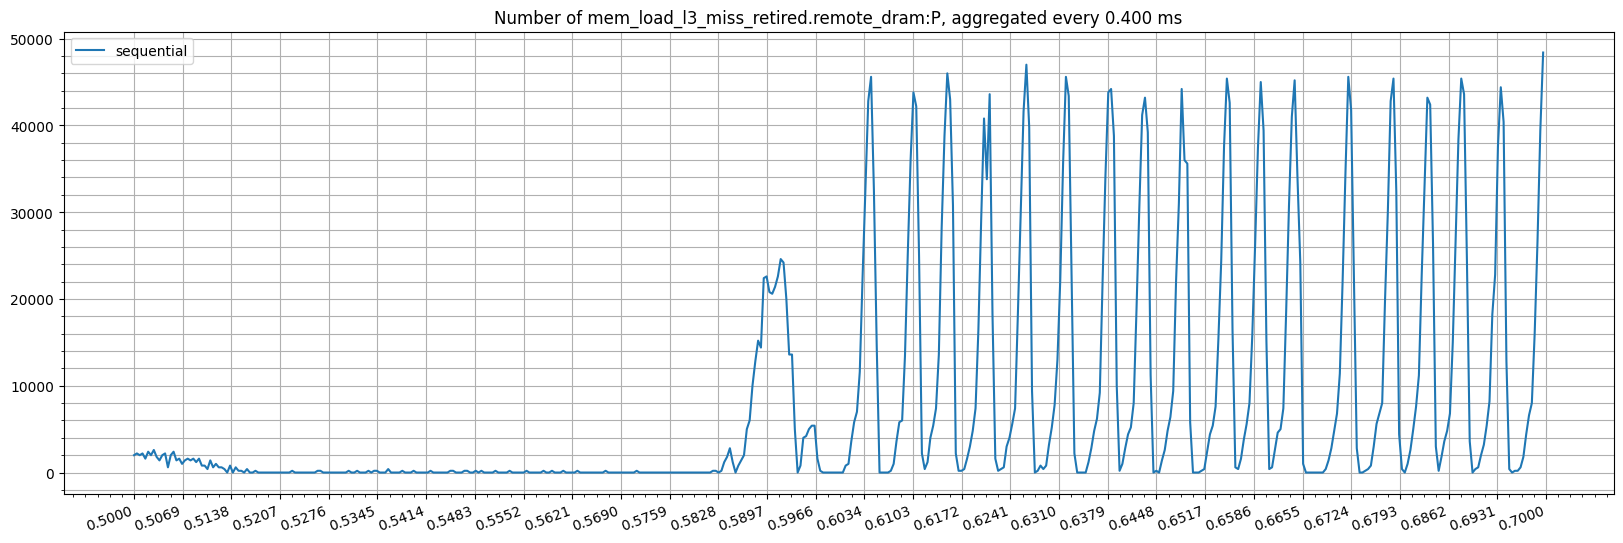

In [11]:
# plot_event_over_time([seq_df, sock_df], ["sequential", "sockorder"], cpuids = [25], event=MEM_EVENTS.load_l3_miss_remote_dram, bins=500, min_t=0.5, max_t=0.7, w=20, h=6)
plot_event_over_time([seq_data.access_df], ["sequential"], MEM_EVENTS.load_l3_miss_remote_dram, bins=500, min_t=0.5, max_t=0.7, w=20, h=6)

### Event counts per CPU

In [12]:
def plot_event_count_per_cpu(dfs: List[pd.DataFrame], names: List[str], event: str) :
    dfs = [df.loc[df['event'] == event] for df in dfs]
    dfs = [df.groupby('cpuid')['period'].sum().reset_index() for df in dfs]
    
    for df, name in zip(dfs, names):
        df['source'] = name
        
    combined_df = pd.concat(dfs)
        
    plt.figure(figsize=(30, 10))
    sns.barplot(x='cpuid', y='period', hue='source', data=combined_df)

    # Add labels and title
    plt.xlabel('CPU')
    plt.ylabel('Number of events')
    plt.title(f"Count of {event} per CPU")
    plt.show()
    

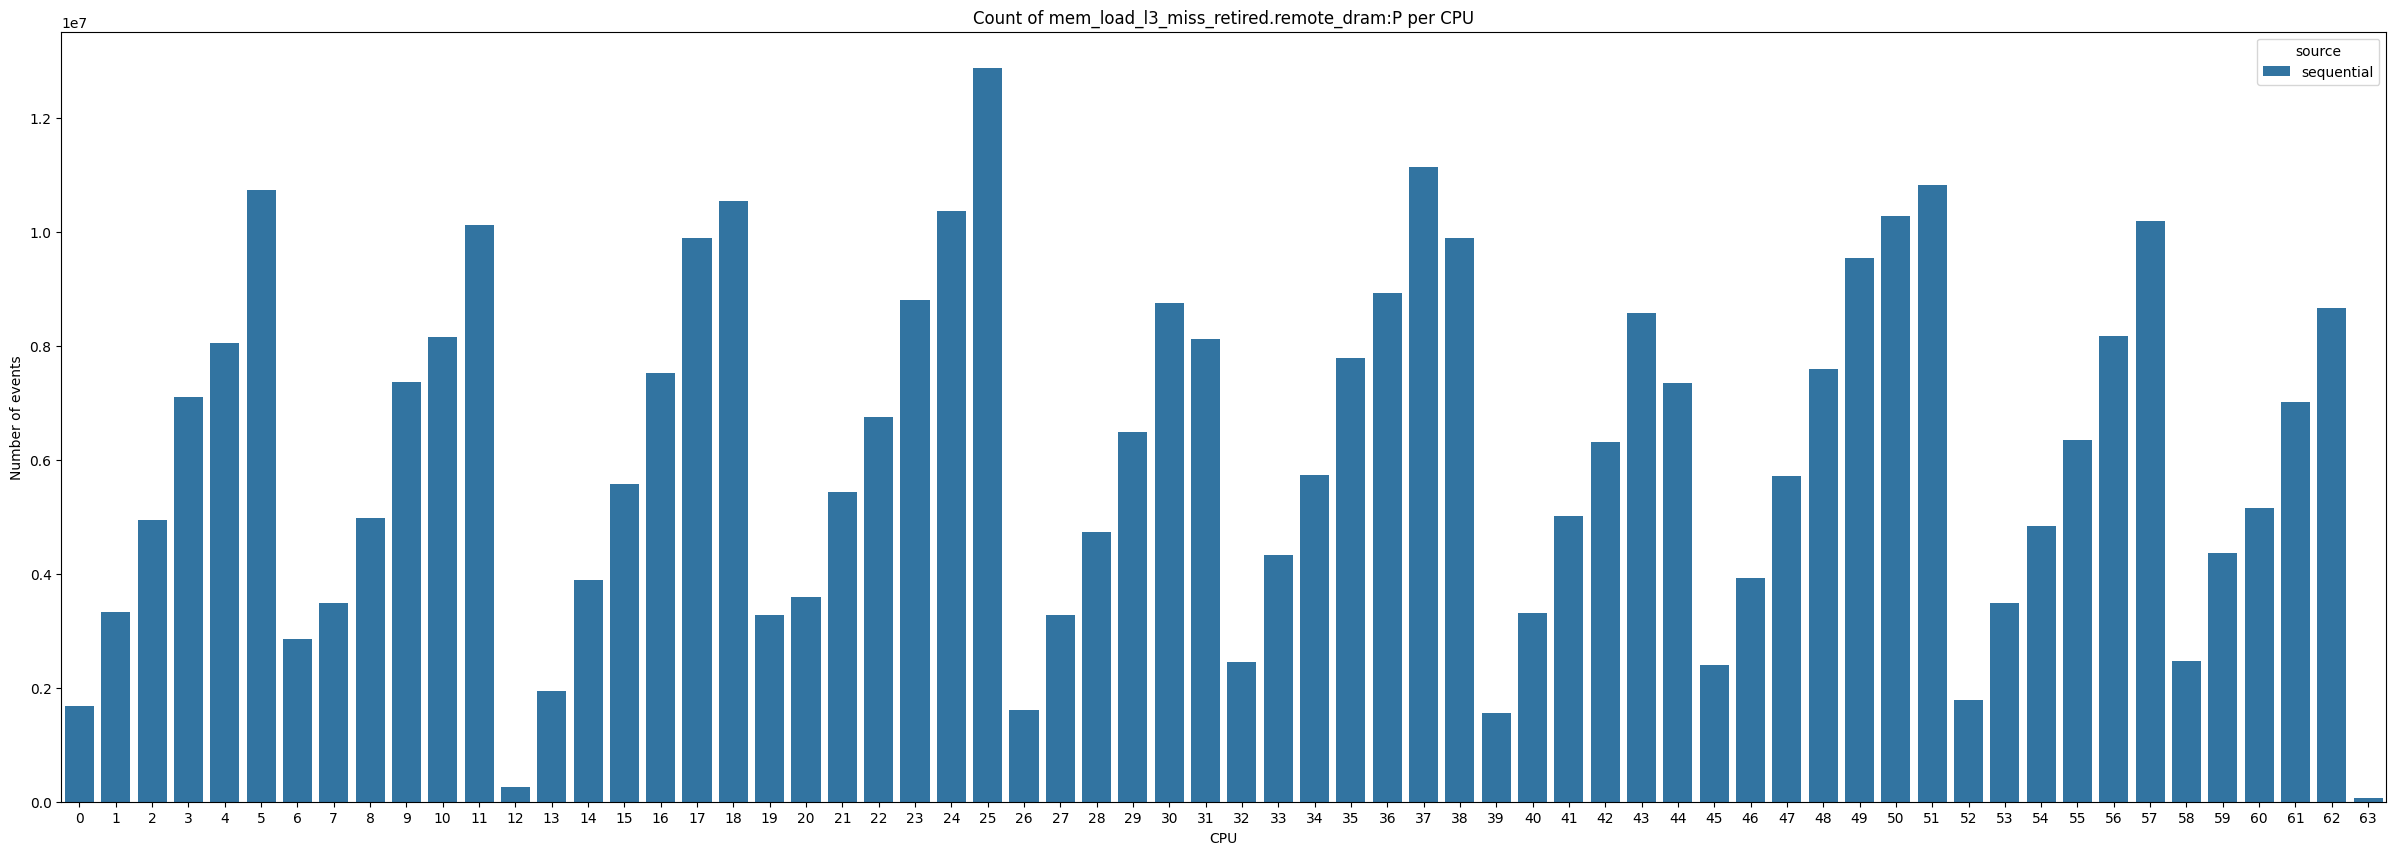

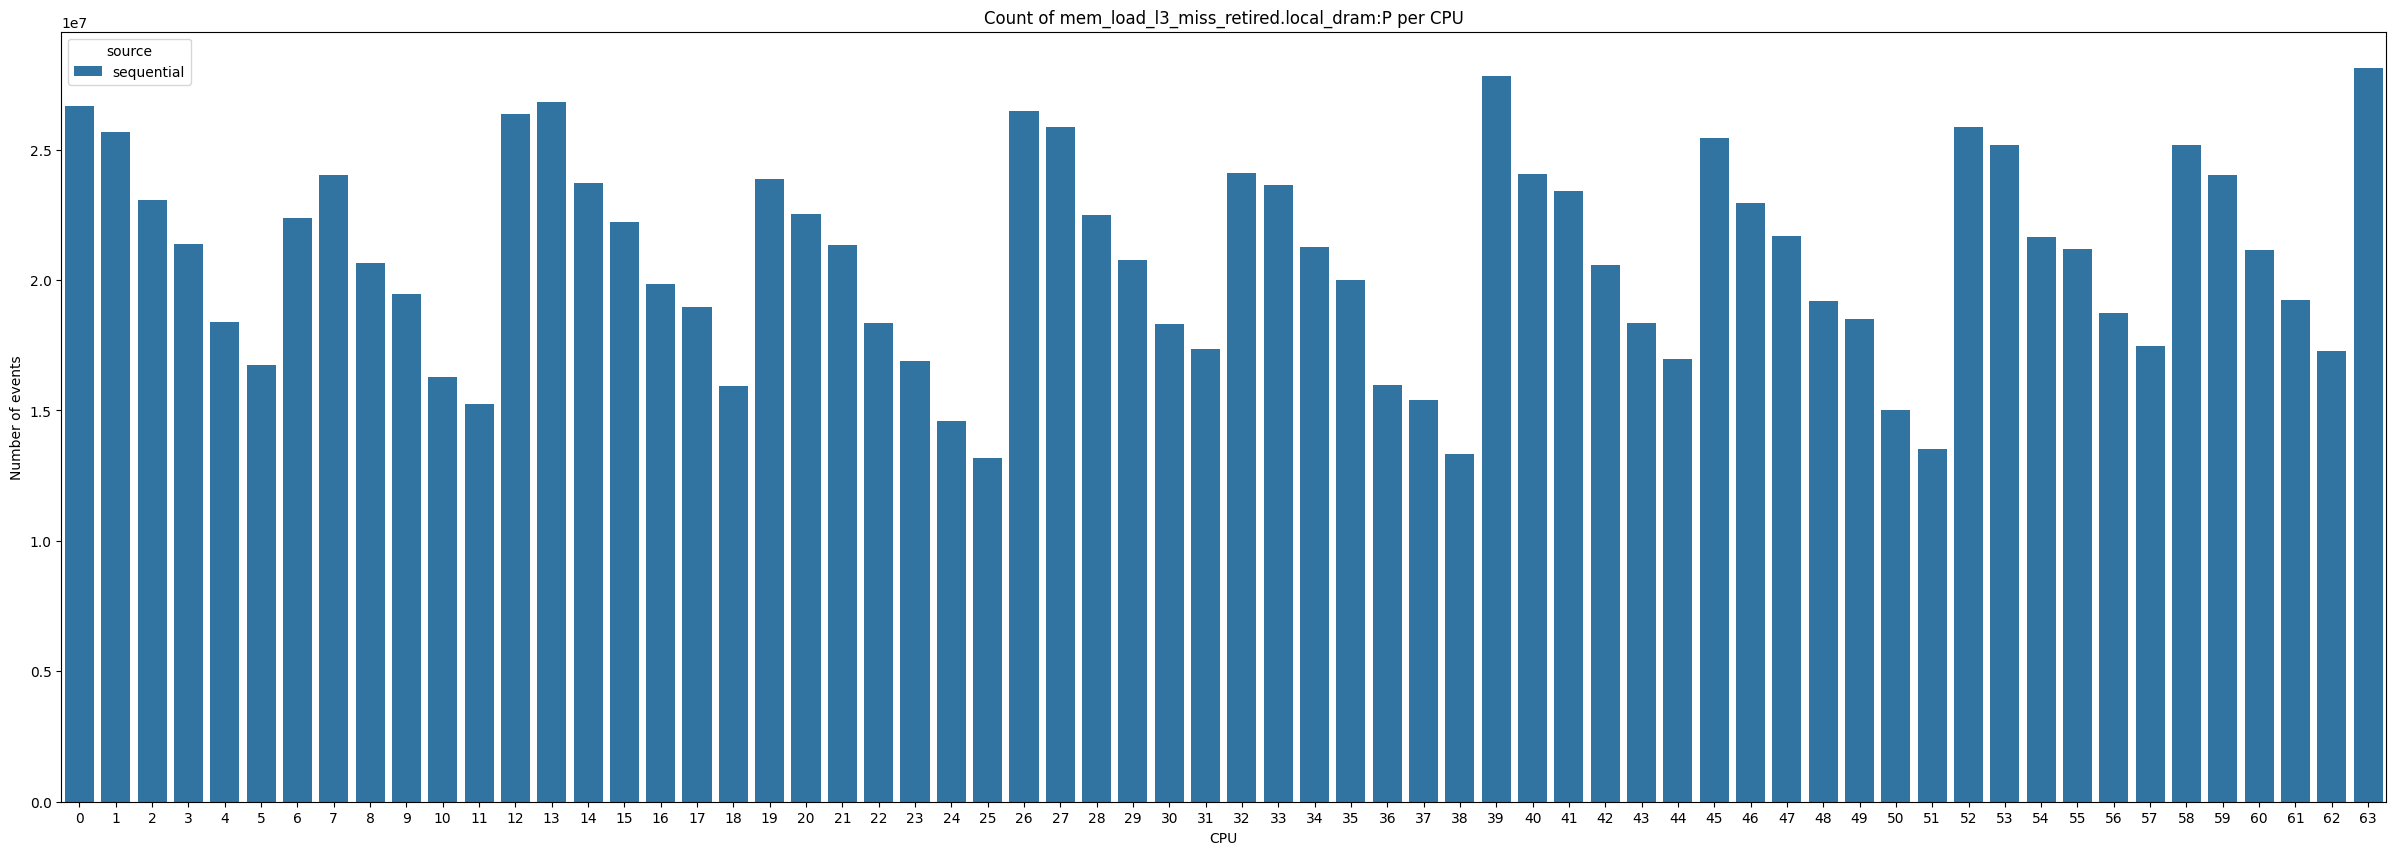

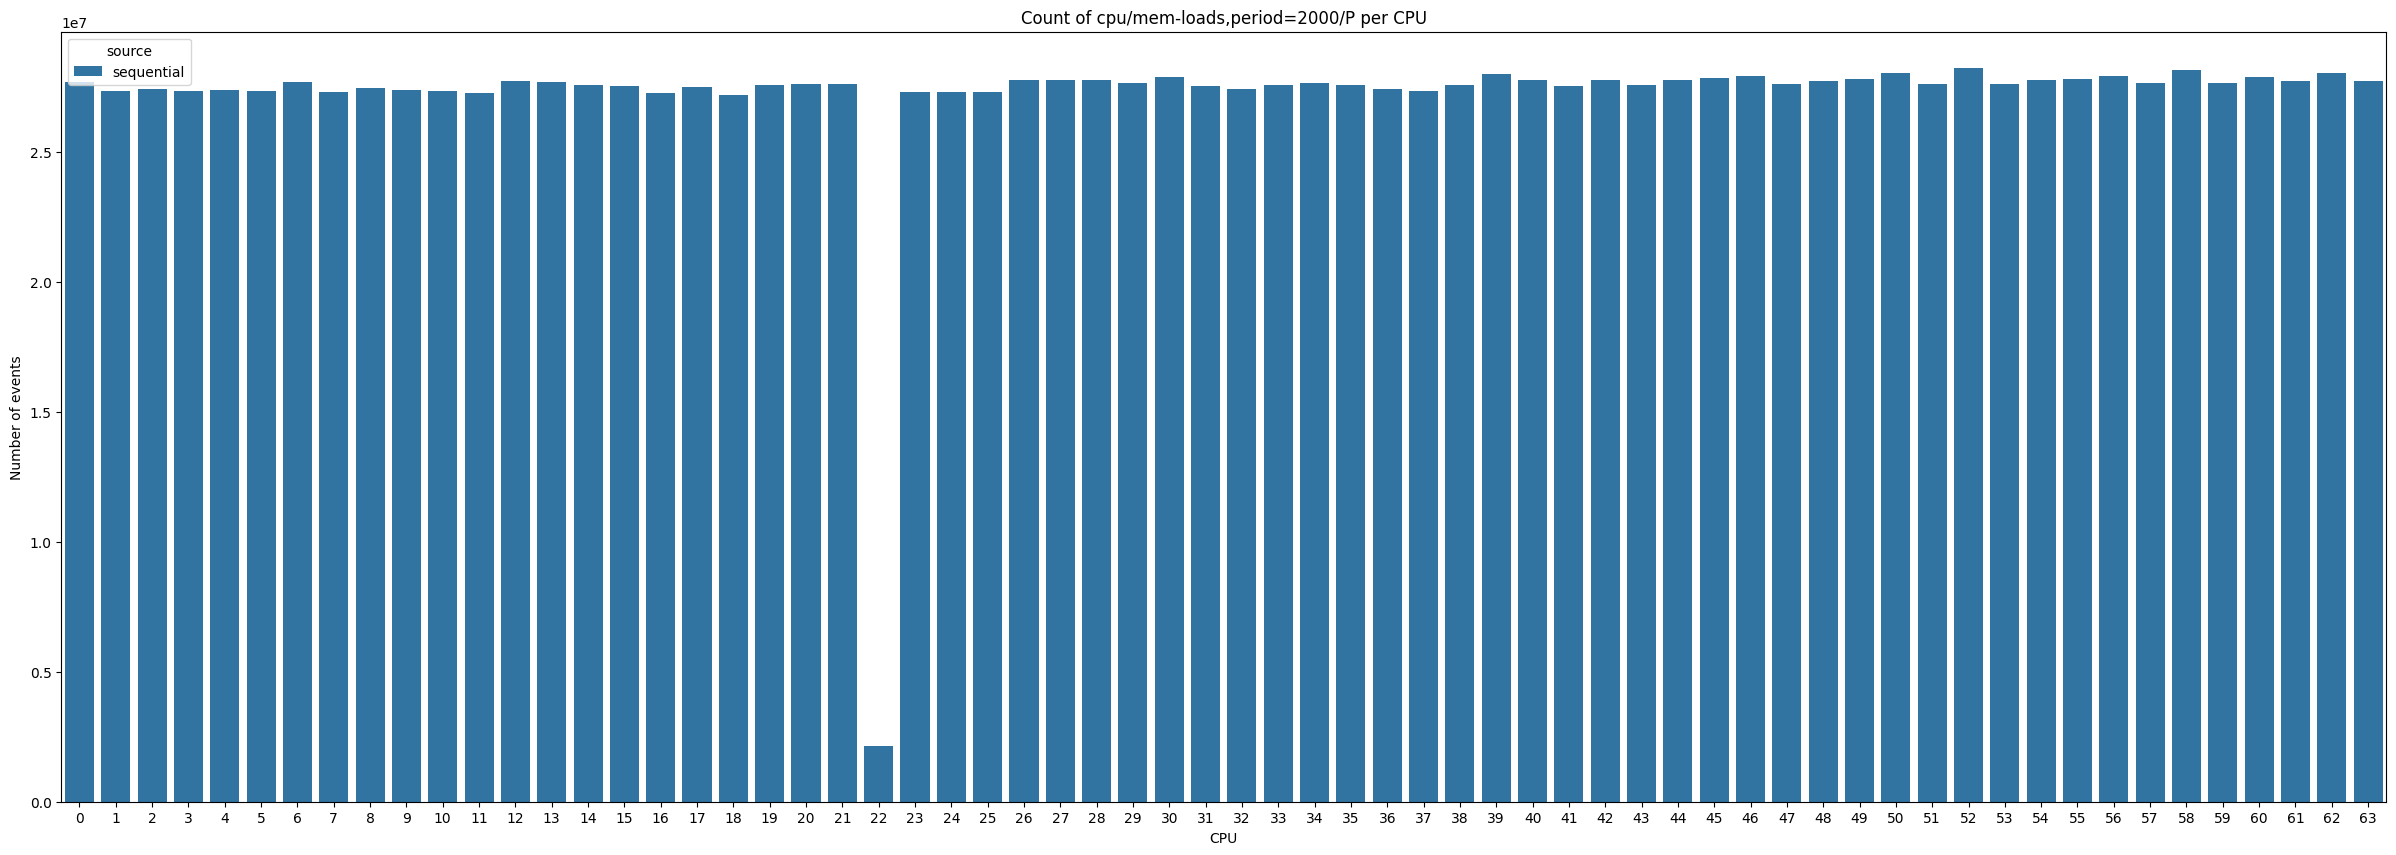

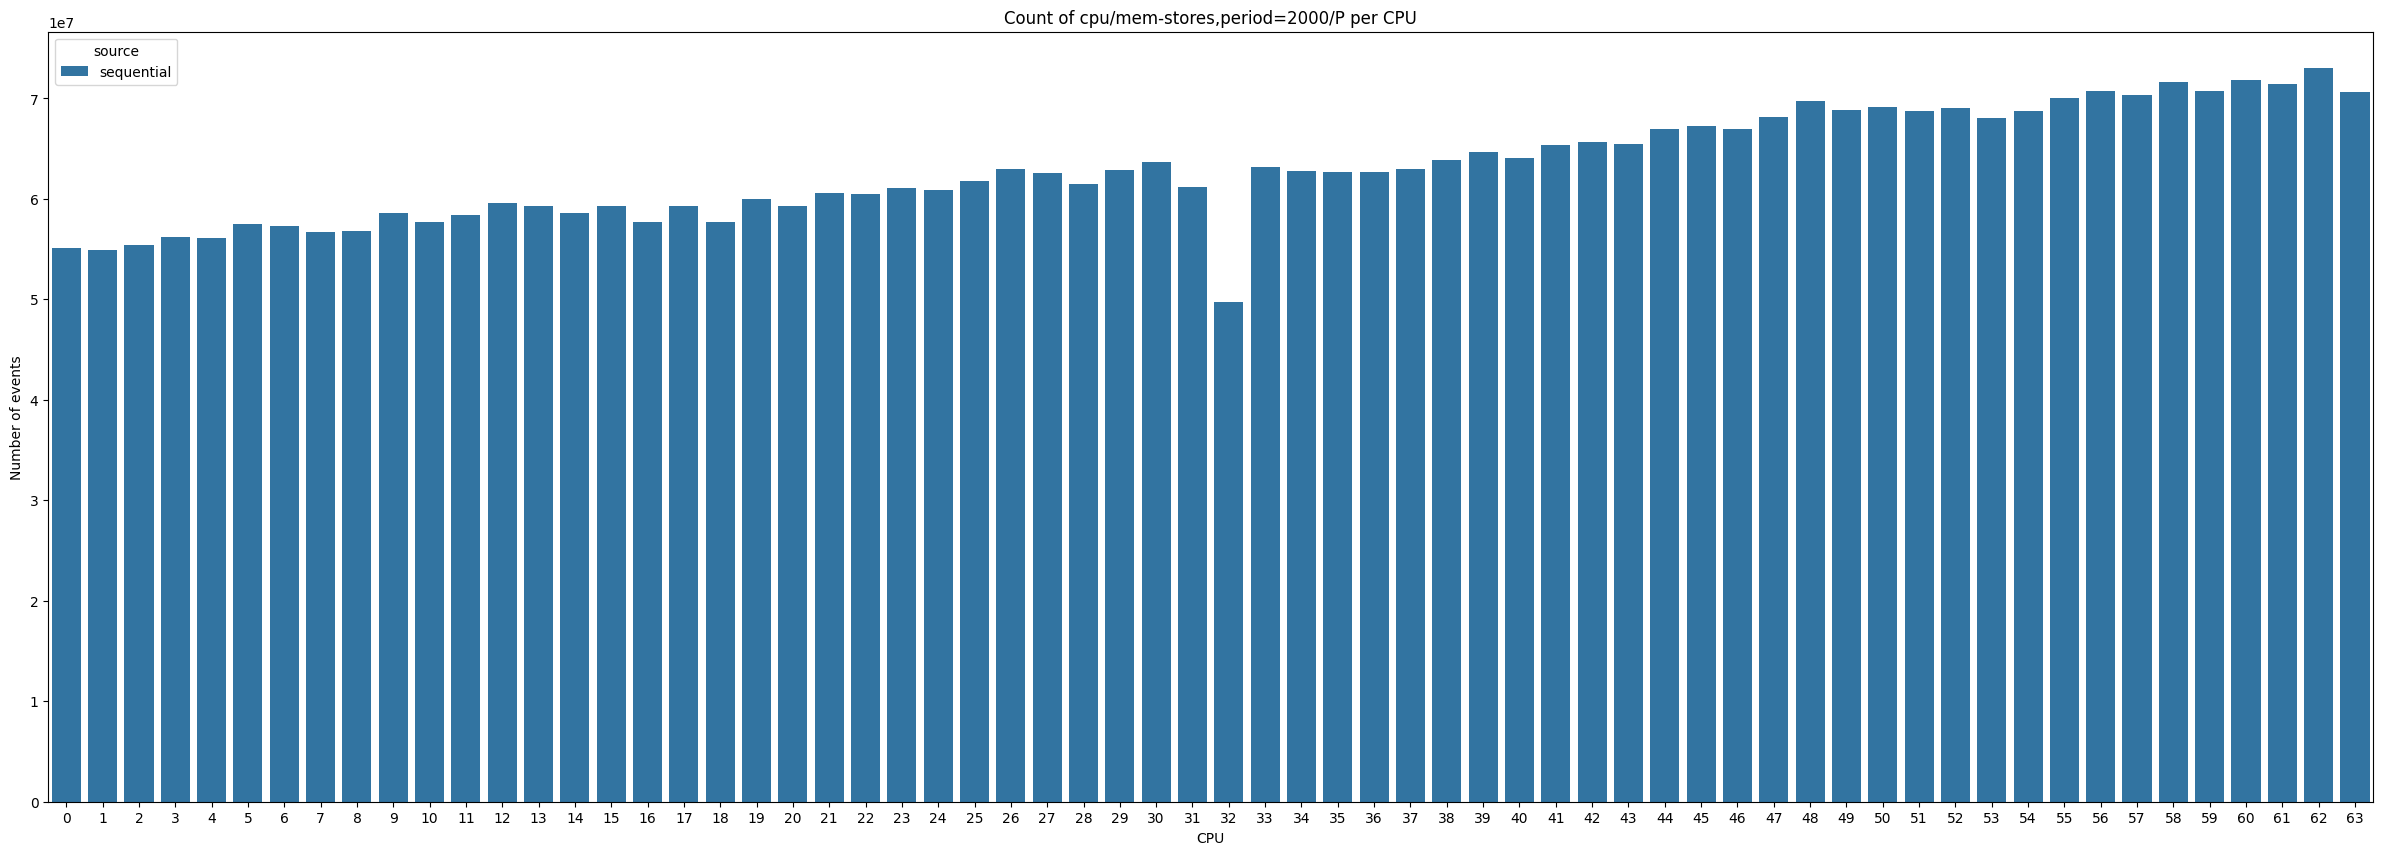

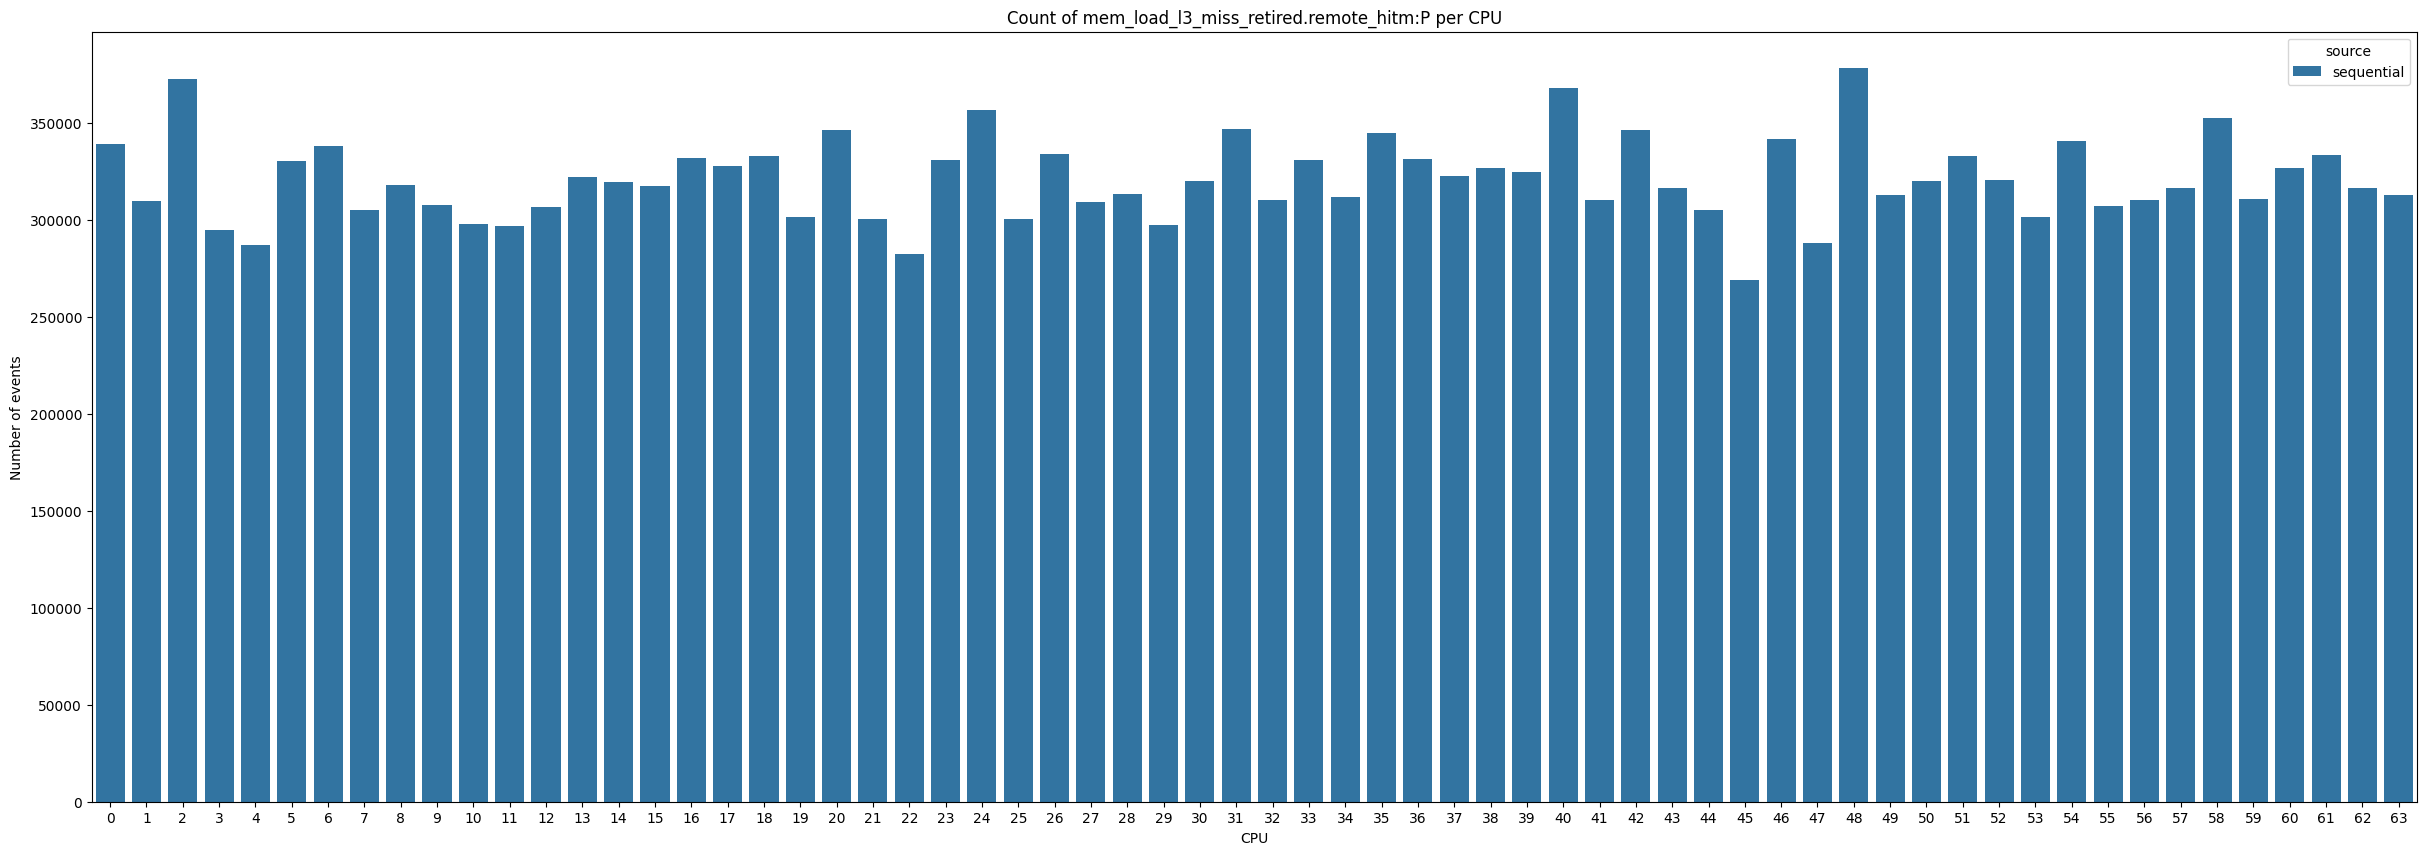

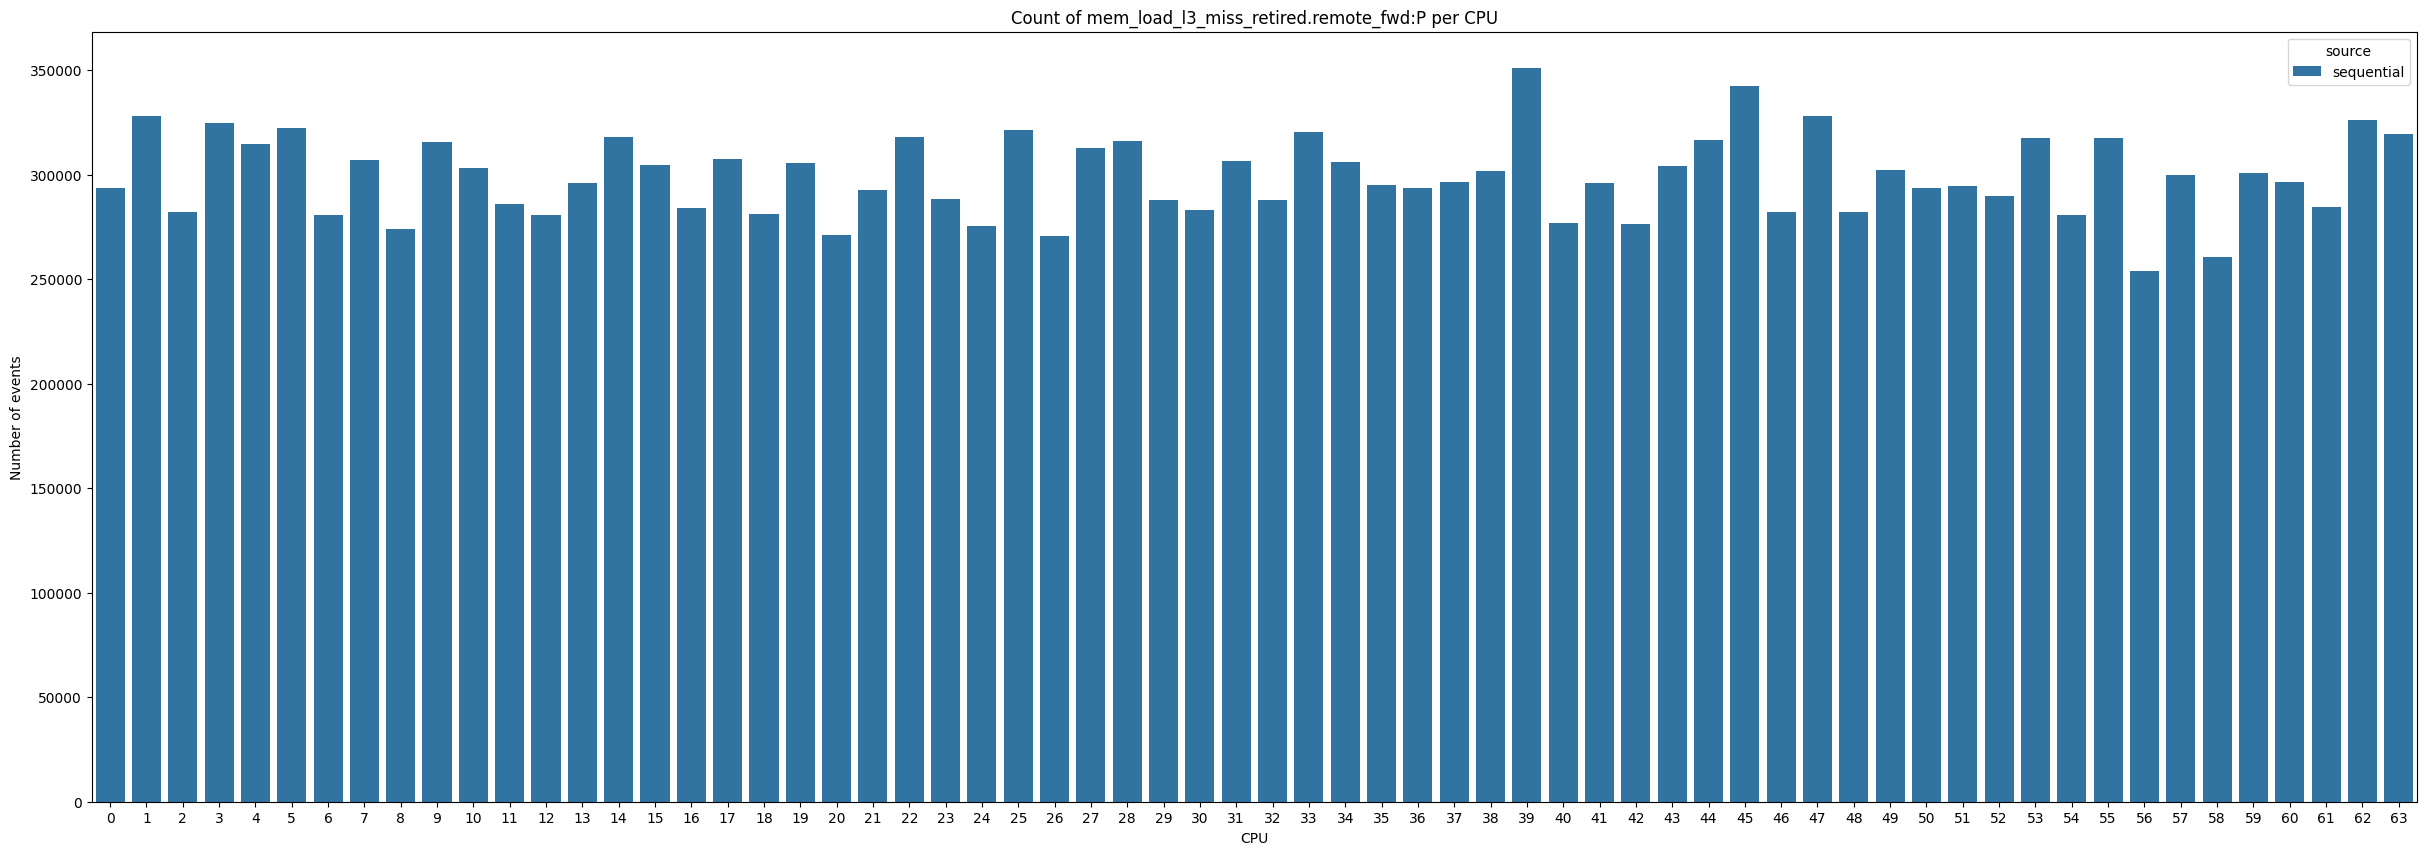

In [13]:
for event in seq_data.access_df['event'].unique() :
    # plot_event_count_per_cpu([seq_df, sock_df], ["sequential", "sockorder"], event)
    plot_event_count_per_cpu([seq_data.access_df], ["sequential"], event)

## Address space

### Vizualization

In [14]:
def bounds_to_relative(df: pd.DataFrame, bounds: Tuple[int, int], variable: str, relative_range = 100):
    min_range = df[variable].min()
    max_range = df[variable].max()
    range = max_range - min_range
    return ((bounds[0] - min_range) * relative_range) / range, ((bounds[1] - min_range) * relative_range) / range

## Visualization of memory

TODO : Do the same thing but over time

In [15]:
def plot_physical_memory_map_subsets(config_data: ConfigData, outer_clusters_size = 1e10, inner_clusters_size = 1e8):
    df = config_data.access_df
    outer_groups = get_groups(df['phys'].to_numpy(), outer_clusters_size, 1000)
    print_groups(outer_groups)
        
    fig, axs = plt.subplots(1, len(outer_groups), figsize=(40, 40))

    for i, og in enumerate(outer_groups):
        inner_df = extract_group(df, og, variable="phys").sort_values("phys").reset_index(drop=True)
        sorted_local_physaddr = inner_df["phys"].to_numpy()
        inner_groups = get_groups(sorted_local_physaddr, inner_clusters_size, 1000)
        # print_groups(inner_groups)
        
        axs[i].plot(range(len(sorted_local_physaddr)), sorted_local_physaddr)
        for cluster in inner_groups :
            axs[i].axhline(y=cluster[0], color='g', linestyle='--', linewidth=0.2)
            axs[i].axhline(y=cluster[1], color='purple', linestyle='--', linewidth=0.2)
            
        for nub in config_data.nodes_phys_mem_upper_boundaries:
            if nub >= og[0] and nub < og[1]:
                axs[i].axhline(y=nub, color='r', linestyle='--', linewidth=0.8)
            
        relative_bounds = bounds_to_relative(df, og, 'phys')
        axs[i].set_title(f"{'{:.2f}'.format(relative_bounds[0])} - {'{:.2f}'.format(relative_bounds[1])} % of entire address space")
        
        l3_miss_dram_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_dram:P"]
        l3_miss_fwd_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_fwd:P"]
        l3_miss_hitm_df = inner_df.loc[inner_df['event'] == "mem_load_l3_miss_retired.remote_hitm:P"]
        
        if len(l3_miss_dram_df) > 0:
            axs[i].scatter(l3_miss_dram_df.index, l3_miss_dram_df['phys'], label="l3 miss remote dram", color='r', s=15, alpha=0.5, zorder=3)
        if len(l3_miss_fwd_df) > 0:
            axs[i].scatter(l3_miss_fwd_df.index, l3_miss_fwd_df['phys'], label="l3 miss remote fwd", color='tab:orange', s=10, alpha=0.5, zorder=4)
        if len(l3_miss_hitm_df) > 0:
            axs[i].scatter(l3_miss_hitm_df.index, l3_miss_hitm_df['phys'], label="l3 miss remote hitm", color='tab:pink', s=10, alpha=0.5, zorder=5)
            
    plt.show()
    
    
    
def plot_virtual_memory_map(config_data: ConfigData, min_addr: Optional[int] = None, max_addr: Optional[int] = None, outer_clusters_size = 1e10, inner_clusters_size = 1e8):
    # fig, axs = plt.subplots(1, len(outer_groups), figsize=(40, 40))
    
    if min_addr is not None or max_addr is not None :
        access_df = filter_in_bounds(config_data.access_df, (min_addr, max_addr), "virt")
    else:
        access_df = config_data.access_df
    sorted_access_virt = access_df["virt"].to_numpy()
    sorted_access_virt.sort()
    
    plt.plot(range(len(sorted_access_virt)), sorted_access_virt)
    plt.show()

In [17]:

# plot_virtual_memory_map(seq_data)

for object_name in seq_data.objects_addr_df['name']:
    bounds = bounds_for_object(seq_data, object_name)
    plot_virtual_memory_map(seq_data, min_addr=bounds[0], max_addr=bounds[1])

Group 0 -- bounds : (4295264792, 14243856376), width : 9.949e+09, size : 1167469
Group 1 -- bounds : (14508327152, 18035506736), width : 3.527e+09, size : 2043275
Group 2 -- bounds : (103345553448, 113141350120), width : 9.796e+09, size : 743808
Group 3 -- bounds : (113397923840, 123226366164), width : 9.828e+09, size : 1866142
Group 4 -- bounds : (123418423568, 129665388456), width : 6.247e+09, size : 113472
Group 5 -- bounds : (199347683584, 199447537832), width : 9.985e+07, size : 17910


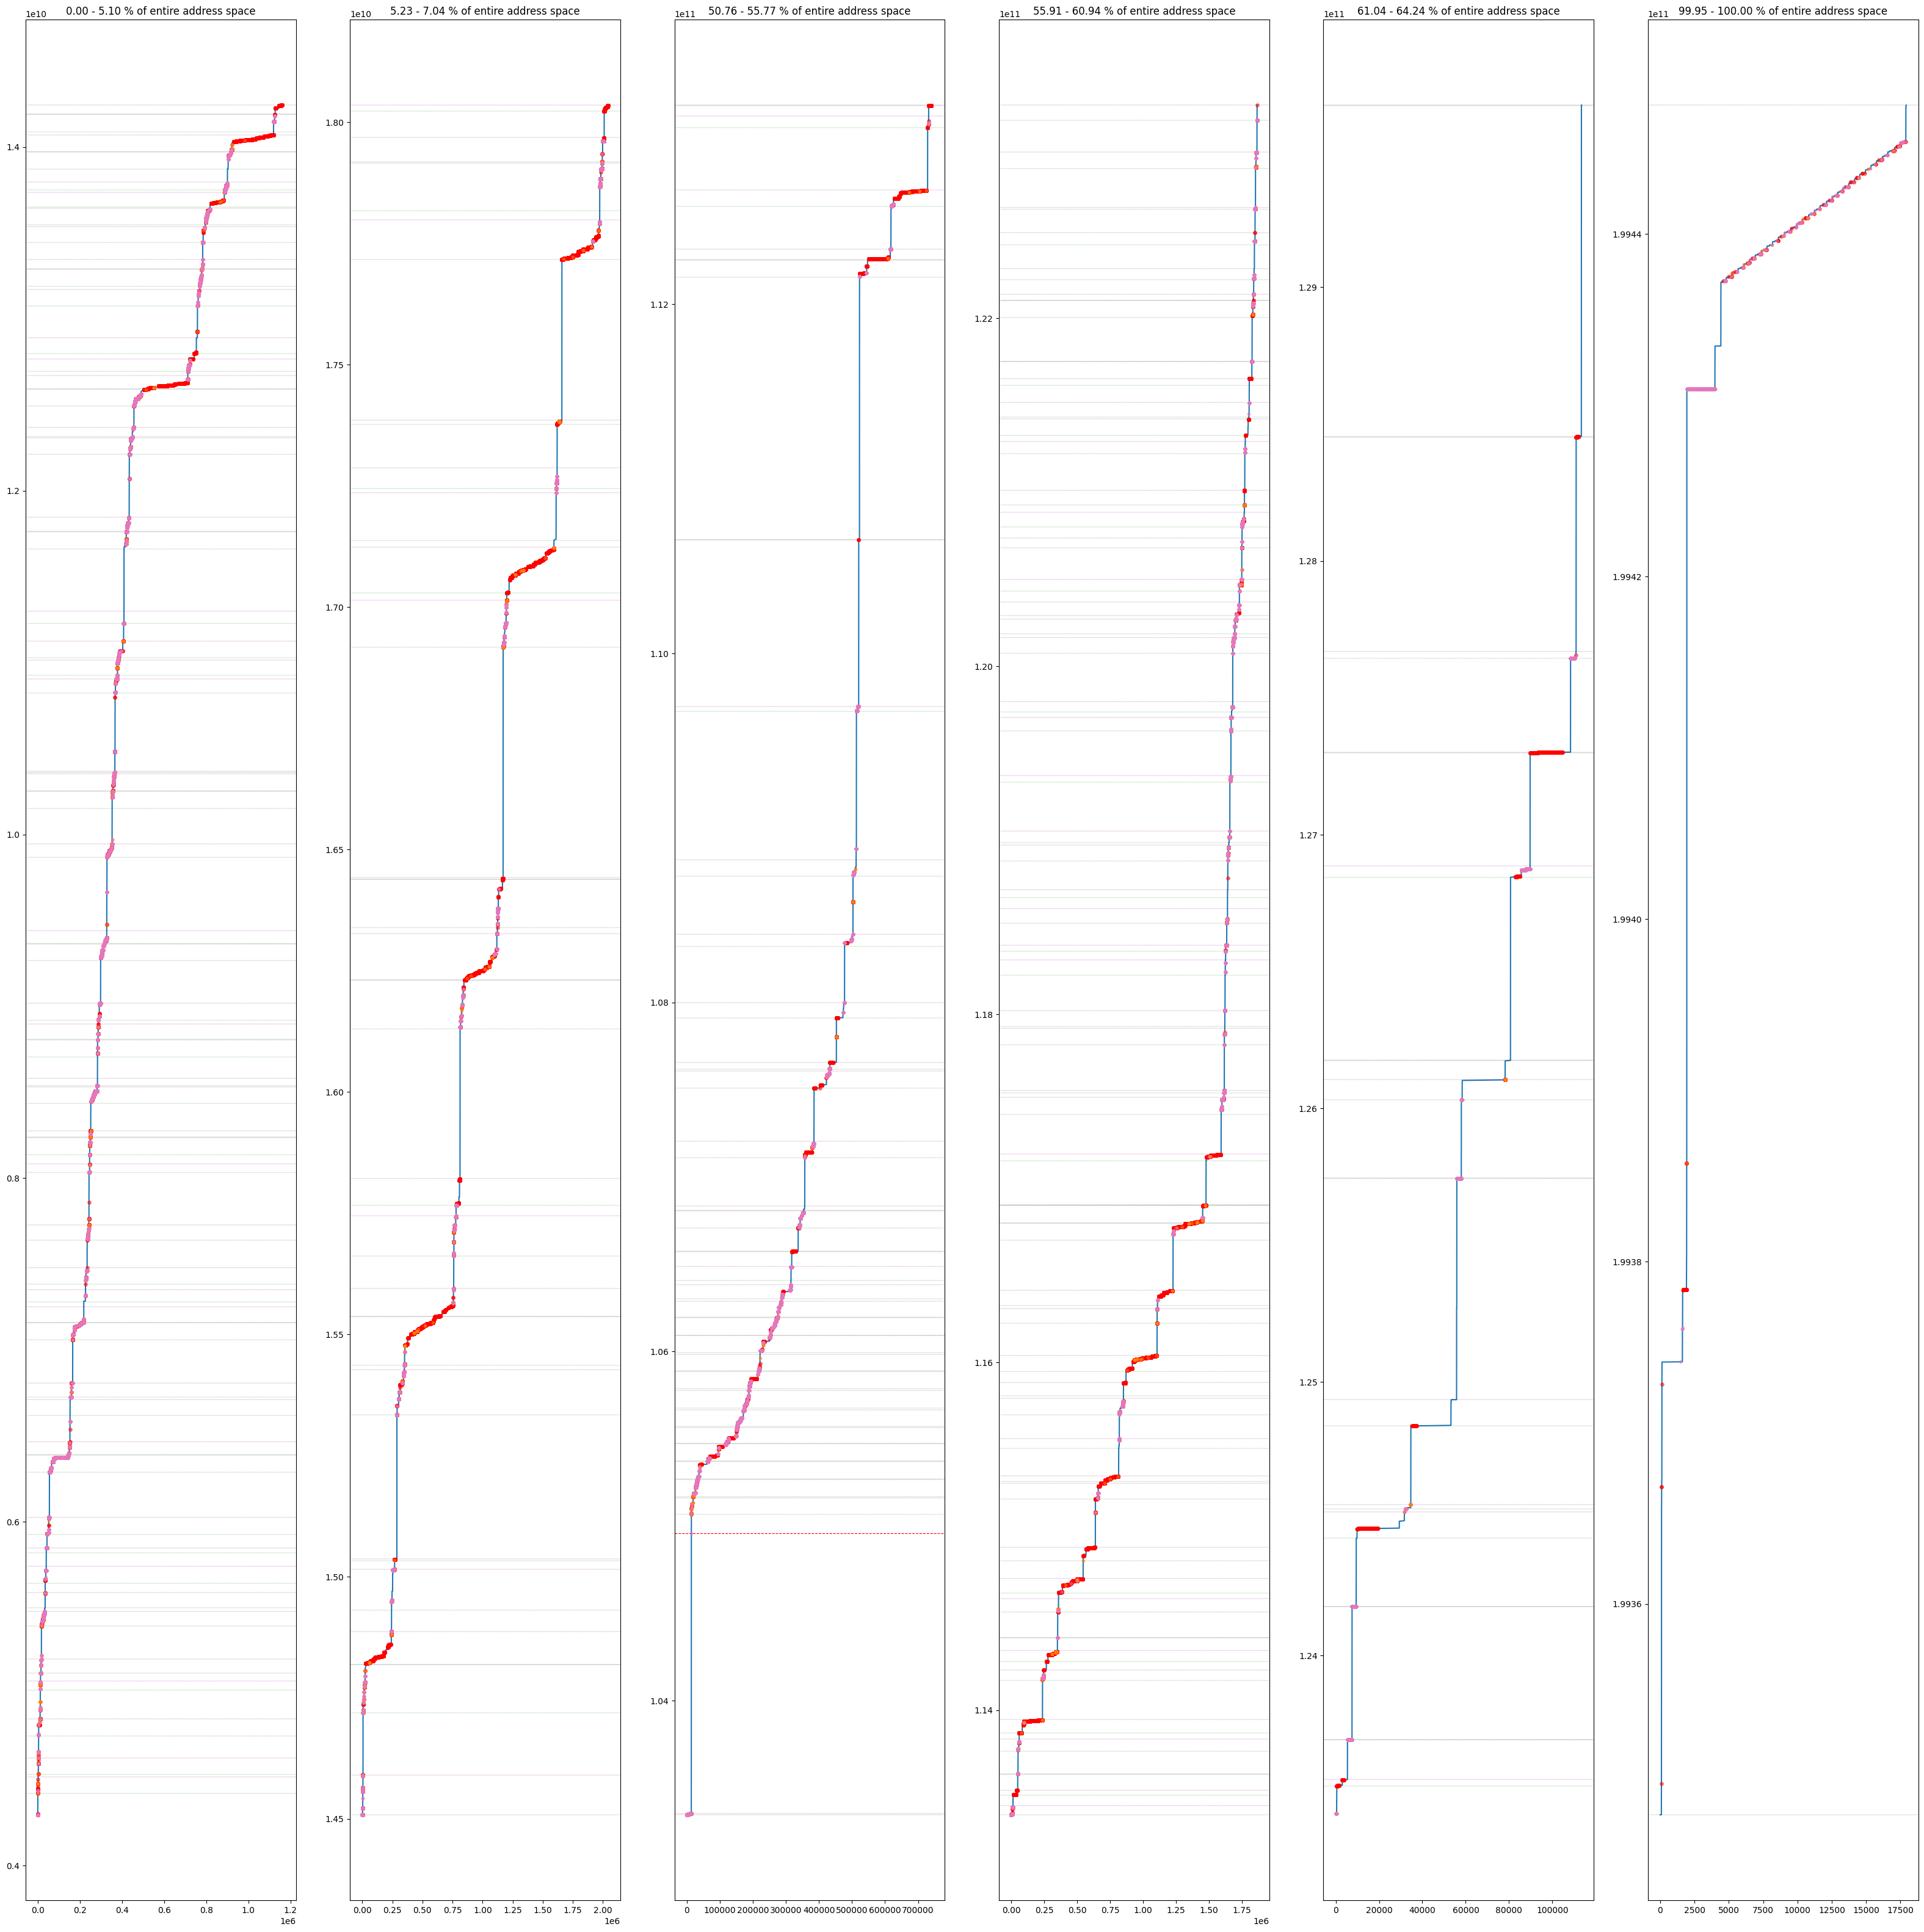

In [115]:
plot_physical_memory_map(seq_data)

In [32]:
test_df = seq_data.alloc_df
test_df['end_addr'] = (test_df['pfn'] + (2 ** test_df['order'])) * PAGE_SIZE
test_df['end_addr']

0        104311816192
1        104324825088
2        207162654720
3        104409272320
4        115887288320
             ...     
12575     15082926080
12576     15082930176
12577     11102572544
12578      7192760320
12579     11883896832
Name: end_addr, Length: 12580, dtype: int64

In [27]:
def addr_pfn(phys_addr: int):
    return int(phys_addr & ~(perf_parser.page_size - 1)) // perf_parser.page_size

def plot_phys_mem_with_alloc(config_data: ConfigData, cpuid = [], exclude_cpuid = [], 
             min_addr: Optional[int] = None, max_addr: Optional[int] = None, 
             min_t: Optional[int] = None, max_t: Optional[int] = None, 
             w = 60, h = 30, dot_size = 10):
    
    addr_type = "phys"
    alloc_df = config_data.alloc_df
    df = config_data.access_df
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    cpu_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    bounded_df = cpu_df
    
    if min_addr is not None or max_addr is not None:
        bounded_df = filter_in_bounds(bounded_df, (min_addr, max_addr), addr_type)
        alloc_df = filter_in_bounds(alloc_df, (None, addr_pfn(max_addr) + 1), 'pfn')
        alloc_df['end_addr'] = (alloc_df['pfn'] + (2 ** alloc_df['order'])) * perf_parser.page_size
        alloc_df = alloc_df.loc[alloc_df['end_addr'] >= min_addr]
        # alloc_df = filter_in_bounds(alloc_df, (addr_pfn(min_addr), addr_pfn(max_addr)), 'pfn')
        
    if min_t is not None or max_t is not None :
        bounded_df = filter_in_bounds(bounded_df, (min_t, max_t), 'time')
        alloc_df = filter_in_bounds(alloc_df, (min_t, max_t), 'time')
        
    me_names = get_memory_event_names(bounded_df)
    # alloc_df = bounded_df.loc[bounded_df['event'].str.contains("alloc")]
    loads_df = bounded_df.loc[bounded_df['event'] == me_names.loads]
    stores_df = bounded_df.loc[bounded_df['event'] == me_names.stores]
    l3_miss_dram_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    cpu_cmap = plt.get_cmap('tab10')
    
    print(f"Plotting {len(alloc_df)} allocations")
    display(alloc_df)
    if len(alloc_df) > 0:
        for i, alloc_row in alloc_df.iterrows():
        # for time, pfn in zip(alloc_df['time'], alloc_df['pfn']):
            start_phys_addr = alloc_row['pfn'] * perf_parser.page_size
            end_phys_addr = (alloc_row['pfn'] + (1 << alloc_row['order'])) * perf_parser.page_size
            # print(f"start_phys_addr : {start_phys_addr}, end_phys_addr : {end_phys_addr}")
            color = cpu_cmap(alloc_row['cpuid'] % cpu_cmap.N)
            plt.vlines(alloc_row['time'], ymin=start_phys_addr, ymax=end_phys_addr, linewidth=2, colors=color)
            plt.scatter([alloc_row['time'], alloc_row['time']], [start_phys_addr, end_phys_addr], marker='_', color=color)
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df[addr_type], label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df[addr_type], label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df[addr_type], label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df[addr_type], label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df[addr_type], label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df[addr_type], label=f"CPU {cid}", linestyle='--', linewidth=0.6, color=cpu_cmap(cid % cpu_cmap.N), alpha=0.5)
        
    plt.gcf().set_size_inches(w, h)
    plt.minorticks_on()
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel(addr_type)
    plt.title(f"Scatter plot of {addr_type} addresses over time")
    plt.legend(title='Cache Result', loc='upper right')
    plt.show()

In [28]:
def plot_mem(df: pd.DataFrame, virtual: bool, cpuid = [], exclude_cpuid = [], min_t = None, max_t = None, w = 60, h = 30, dot_size = 10) :
    column = "virt" if virtual else "phys"
    cpu_df = df.loc[df['cpuid'].isin(cpuid)] if cpuid else df
    cpu_df = df.loc[~df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else cpu_df
    bounded_df = cpu_df
    
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        bounded_df = filter_in_bounds(bounded_df, (min_t, max_t), 'time')
        
    me_names = get_memory_event_names(bounded_df)
    alloc_df = bounded_df.loc[bounded_df['event'].str.contains("alloc")]
    loads_df = bounded_df.loc[bounded_df['event'] == me_names.loads]
    stores_df = bounded_df.loc[bounded_df['event'] == me_names.stores]
    l3_miss_dram_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = bounded_df.loc[bounded_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    print(f"Plotting {len(alloc_df)} allocations")
    if column == 'phys' and len(alloc_df) > 0:
        for time, start_phys_addr in zip(alloc_df['time'], alloc_df['phys']):
            end_phys_addr = start_phys_addr + perf_parser.page_size
            plt.vlines(time, ymin=start_phys_addr, ymax=end_phys_addr, linewidth=100)
            plt.plot([time, time], [start_phys_addr, end_phys_addr], '-')
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df[column], label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df[column], label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df[column], label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df[column], label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df[column], label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    # TODO Plot the other types of L3 miss with different color like orange and purple
    # plt.scatter(l3_miss_remote_df['time'], l3_miss_remote_df['phys'], label="l3 miss remote dram", color='r', s=3, alpha=0.5, zorder=10)
    
    cpuids = bounded_df['cpuid'].unique()
    for cid in cpuids :
        curr_df = bounded_df.loc[bounded_df['cpuid'] == cid]
        plt.plot(curr_df['time'], curr_df[column], label=f"CPU {cid}", linestyle='--', linewidth=0.4, alpha=0.5)
        
    plt.gcf().set_size_inches(w, h)
    plt.minorticks_on()
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.title(f"Scatter plot of {column} addresses over time")
    plt.legend(title='Cache Result', loc='upper right')
    plt.show()

In [29]:
def plot_mem_virtual(config_data: ConfigData, cpuid = [], exclude_cpuid = [], 
                     min_addr: Optional[int] = None, max_addr: Optional[int] = None, 
                     min_t: Optional[float] = None, max_t: Optional[float] = None, w = 30, h = 15, dot_size = 40) :
    column = "virt"
    access_df = config_data.access_df
    alloc_df = config_data.alloc_df.dropna(subset=["virt_page"]) # TODO Check
    alloc_df['start_addr'] = alloc_df['virt_page'] * perf_parser.page_size
    alloc_df['end_addr'] = (alloc_df['virt_page'] + (2 ** alloc_df['order'])) * perf_parser.page_size # Excluded
    
    if min_t is not None or max_t is not None:
        access_df = filter_in_bounds(access_df, (min_t, max_t), 'time')
        alloc_df = filter_in_bounds(alloc_df, (min_t, max_t), 'time')
        
    print(f"Max time : {access_df['time'].max()}")
    if max_t is None:
        max_t = access_df['time'].max()
        
    if min_addr is not None or max_addr is not None:
        access_df = filter_in_bounds(access_df, (min_addr, max_addr), column)
        alloc_df = filter_in_bounds(alloc_df, (None, max_addr), 'start_addr')
        alloc_df = filter_in_bounds(alloc_df, (min_addr, None), "end_addr")
        # +1 because otherwise filter will exclude last page from search
        # alloc_df = filter_in_bounds(alloc_df, (None, (max_addr >> PAGE_SIZE_ORDER) + 1), 'virt_page')
        # alloc_df['end_addr'] = (alloc_df['virt_page'] + (2 ** alloc_df['order'])) * PAGE_SIZE
        # alloc_df = alloc_df.loc[alloc_df['end_addr'] > min_addr]
        
    access_df = access_df.loc[access_df['cpuid'].isin(cpuid)] if cpuid else access_df
    access_df = access_df.loc[~access_df['cpuid'].isin(exclude_cpuid)] if exclude_cpuid else access_df
    
    me_names = get_memory_event_names(access_df)
    print(access_df['event'].value_counts())
    # alloc_df = bounded_df.loc[bounded_df['event'].str.contains("alloc")]
    loads_df = access_df.loc[(access_df['event'] == me_names.loads) | (access_df['event'] == me_names.load_l3_miss_local_dram)]
    stores_df = access_df.loc[access_df['event'] == me_names.stores]
    l3_miss_dram_df = access_df.loc[access_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = access_df.loc[access_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = access_df.loc[access_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    cpu_cmap = plt.get_cmap('tab10')
    
    # event
    # kmem:mm_page_alloc_zone_locked    8818
    # kmem:kmem_cache_free              7023
    # kmem:rss_stat                     4706
    # kmem:mm_page_free                 3997
    # kmem:mm_page_alloc                3782
    # kmem:mm_page_free_batched         3057
    # kmem:mm_page_pcpu_drain           1733
    # kmem:kmem_cache_alloc             1260
    # kmem:kfree                        1059
    # kmem:kmalloc                       567
    # Name: count, dtype: int64
    
    alloc_type_color_map = {
        "kmem:mm_page_alloc_zone_locked": "tab:blue",
        "kmem:mm_page_alloc": "tab:green"
    }
    
    print(f"Plotting {len(alloc_df)} allocations")
    if len(alloc_df) > 0:
        for i, alloc_row in alloc_df.iterrows():
            # start_addr = alloc_row['virt_page'] * PAGE_SIZE
            # end_addr = (alloc_row['virt_page'] + (1 << alloc_row['order'])) * PAGE_SIZE
            # print(f"start_phys_addr : {start_phys_addr}, end_phys_addr : {end_phys_addr}")
            cpu_color = cpu_cmap(alloc_row['cpuid'] % cpu_cmap.N)
            type_color = alloc_type_color_map[alloc_row['event']] if alloc_row['event'] in alloc_type_color_map else "tab:gray"
            plt.vlines(alloc_row['time'], ymin=alloc_row['start_addr'], ymax=alloc_row['end_addr'], linewidth=2, colors=cpu_color)
            plt.scatter([alloc_row['time'], alloc_row['time']], [alloc_row['start_addr'], alloc_row['end_addr']], marker='_', color=type_color, s=500)
            # plt.axhline(y=alloc_row['start_addr'], xmin=alloc_row['time'], color='black', linestyle='--')
            # plt.hlines(alloc_row['start_addr'], xmin=alloc_row['time'], xmax=max_t, linestyles=(0, (1, 10)), colors=color, linewidths=0.5)
            plt.hlines(alloc_row['start_addr'], xmin=alloc_row['time'], xmax=max_t, linestyles="--", colors=type_color, linewidths=0.5)
            plt.hlines(alloc_row['end_addr'], xmin=alloc_row['time'], xmax=max_t, linestyles="--", colors=type_color, linewidths=0.5)
            
    # Create a custom Line2D object for the legend
    # custom_line = Line2D([0], [0], color='red', linestyle='--', linewidth=2)

    # Add the custom line to the legend
    # plt.legend([custom_line], ['Dotted Red Line'], loc='upper left')
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df[column], label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df[column], label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df[column], label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df[column], label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df[column], label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    # TODO Plot the other types of L3 miss with different color like orange and purple
    # plt.scatter(l3_miss_remote_df['time'], l3_miss_remote_df['phys'], label="l3 miss remote dram", color='r', s=3, alpha=0.5, zorder=10)
        
    cpuids = list(access_df['cpuid'].unique())
    for cid in cpuids :
        curr_df = access_df.loc[access_df['cpuid'] == cid]
        # plt.plot(curr_df['time'], curr_df[column], label=f"CPU {cid}", linestyle='--', linewidth=0.8, color=cpu_cmap(cid % cpu_cmap.N), alpha=0.5)
        color = cpu_cmap(cid % cpu_cmap.N)
        plt.plot(curr_df['time'], curr_df[column], linestyle='--', linewidth=0.8, color=color, alpha=0.6)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    cpuids = set(cpuid + list(alloc_df.cpuid.unique()))
    for cid in cpuids:
        color = cpu_cmap(cid % cpu_cmap.N)
        handles.append(Line2D([0], [0], color=color, linestyle='--', linewidth=1))
        labels.append(f'CPU {cid}')
    
    for key, color in alloc_type_color_map.items():
        handles.append(Line2D([0], [0], color=color, linewidth=1))
        labels.append(key)
        
    plt.gcf().set_size_inches(w, h)
    plt.minorticks_on()
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    plt.xlabel('Time')
    plt.ylabel("Virtual address")
    plt.title(f"Scatter plot of virtual addresses over time. Same color per CPU across accesses and allocations.")
    # plt.legend(title='Cache Result', loc='upper right')
    # plt.legend([custom_line], ['Dotted Red Line'], loc='upper left')
    plt.legend(handles=handles, labels=labels, loc='upper right')
    plt.show()

## Fixed page investigation

In here we want to get the pfn for an address, and then filter all the access to that particular pfn.
x axis : time
y axis : cpu

In [19]:
test_df = filter_cpu(seq_data.access_df, 18)
test_df = filter_in_bounds(test_df, (None, 0.9), "time")
# test_df = filter_in_bounds(seq_data.access_df, (TIME_START, TIME_END), "time")
test_df = test_df.loc[test_df['event'] == MEM_EVENTS.load_l3_miss_remote_dram]
test_df

,cpuid,time,period,event,virt,cache_result,latency,phys,cpu_node,memory_node
272618,18,0.156734,200,mem_load_l3_miss_retired.remote_dram:P,140414219505632,LVL N/A or N/A,0,107230318560,0,1
273785,18,0.157754,200,mem_load_l3_miss_retired.remote_dram:P,140413946408120,LVL N/A or N/A,0,105835244728,0,1
274998,18,0.158686,200,mem_load_l3_miss_retired.remote_dram:P,140413946376064,LVL N/A or N/A,0,105835212672,0,1
276245,18,0.159657,200,mem_load_l3_miss_retired.remote_dram:P,140414218794472,LVL N/A or N/A,0,107229607400,0,1
277468,18,0.160597,200,mem_load_l3_miss_retired.remote_dram:P,140414219458984,LVL N/A or N/A,0,107230271912,0,1
...,...,...,...,...,...,...,...,...,...,...
2120023,18,0.898121,200,mem_load_l3_miss_retired.remote_dram:P,140414372649600,LVL N/A or N/A,0,106443938432,0,1
2120043,18,0.898179,200,mem_load_l3_miss_retired.remote_dram:P,140413612326208,LVL N/A or N/A,0,107319393600,0,1
2120053,18,0.898227,200,mem_load_l3_miss_retired.remote_dram:P,140413612369472,LVL N/A or N/A,0,107319436864,0,1
2120057,18,0.898277,200,mem_load_l3_miss_retired.remote_dram:P,140414372719104,LVL N/A or N/A,0,106444007936,0,1


In [29]:
test_df.loc[2676587]

cpuid                                               35
time                                          0.887998
period                                             100
event           mem_load_l3_miss_retired.remote_dram:P
virt                                   140428801086216
cache_result                            LVL N/A or N/A
latency                                              0
phys                                       20819350280
cpu_node                                             1
memory_node                                          0
Name: 2676587, dtype: object

In [20]:
# Type should be either phys or virt
def plot_page_accesses(df: pd.DataFrame, address: int, addr_type: str, radius = 0, min_t = None, max_t = None, w = 24, dot_size = 15):
    if max_t is not None :
        if min_t is None :
            min_t = 0.0
        df = filter_in_bounds(df, (min_t, max_t), 'time')
        
    mask = ~(perf_parser.page_size - 1)
    pfn = address & mask
    lower_bound = pfn - radius * perf_parser.page_size
    upper_bound = pfn + (radius + 1) * perf_parser.page_size - 1
    
    print(f"Address type : {addr_type}, lower bound : {lower_bound}, upper bound : {upper_bound}, size : {upper_bound - lower_bound + 1}")
    
    pages_df = filter_in_bounds(df, (lower_bound, upper_bound), addr_type)
    cpuids = list(pages_df.cpuid.unique())
    me_names = get_memory_event_names(pages_df)
    loads_df = pages_df.loc[pages_df['event'] == me_names.loads]
    stores_df = pages_df.loc[pages_df['event'] == me_names.stores]
    l3_miss_dram_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_dram]
    l3_miss_fwd_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_fwd]
    l3_miss_hitm_df = pages_df.loc[pages_df['event'] == me_names.load_l3_miss_remote_hitm]
    
    if len(loads_df) > 0:
        plt.scatter(loads_df['time'], loads_df.cpuid, label="Memory loads", color='tab:green', s=dot_size, alpha=0.3, zorder=1)
    if len(stores_df) > 0:
        plt.scatter(stores_df['time'], stores_df.cpuid, label="Memory stores", color='tab:blue', s=dot_size, alpha=0.3, zorder=2)
    if len(l3_miss_dram_df) > 0:
        plt.scatter(l3_miss_dram_df['time'], l3_miss_dram_df.cpuid, label="l3 miss remote dram", color='r', s=dot_size, alpha=0.5, zorder=3)
    if len(l3_miss_fwd_df) > 0:
        plt.scatter(l3_miss_fwd_df['time'], l3_miss_fwd_df.cpuid, label="l3 miss remote fwd", color='tab:orange', s=dot_size, alpha=0.5, zorder=4)
    if len(l3_miss_hitm_df) > 0:
        plt.scatter(l3_miss_hitm_df['time'], l3_miss_hitm_df.cpuid, label="l3 miss remote hitm", color='tab:pink', s=dot_size, alpha=0.5, zorder=5)
    
    plt.gcf().set_size_inches(w, len(cpuids))
    plt.ylim(bottom = min(cpuids) - 1, top = max(cpuids) + 1)
    plt.grid(which="major", axis="y")
    plt.yticks(list(range(min(cpuids), max(cpuids) + 2)))
    plt.show()
    
    return lower_bound, upper_bound, cpuids

Address type : virt, lower bound : 140413607452672, upper bound : 140413617287167, size : 9834496


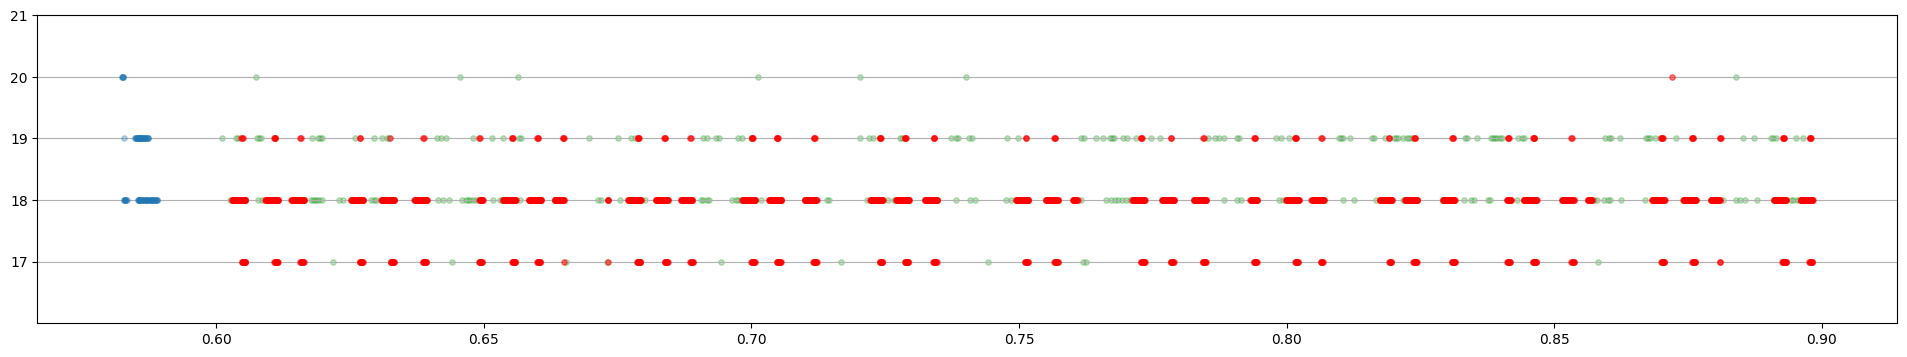

(140413607452672, 140413617287167, [20, 19, 18, 17])

In [25]:
plot_page_accesses(seq_data.access_df, 140413612369472, "virt", radius=1200, max_t=0.9)

/tmp/ipykernel_15030/3130601841.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc_df['start_addr'] = alloc_df['virt_page'] * perf_parser.page_size
/tmp/ipykernel_15030/3130601841.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc_df['end_addr'] = (alloc_df['virt_page'] + (2 ** alloc_df['order'])) * perf_parser.page_size # Excluded


Max time : 0.8999980000007781
event
mem_load_l3_miss_retired.local_dram:P     4503
mem_load_l3_miss_retired.remote_dram:P    1676
cpu/mem-loads,period=2000/P                246
cpu/mem-stores,period=2000/P                80
Name: count, dtype: int64
Plotting 12 allocations


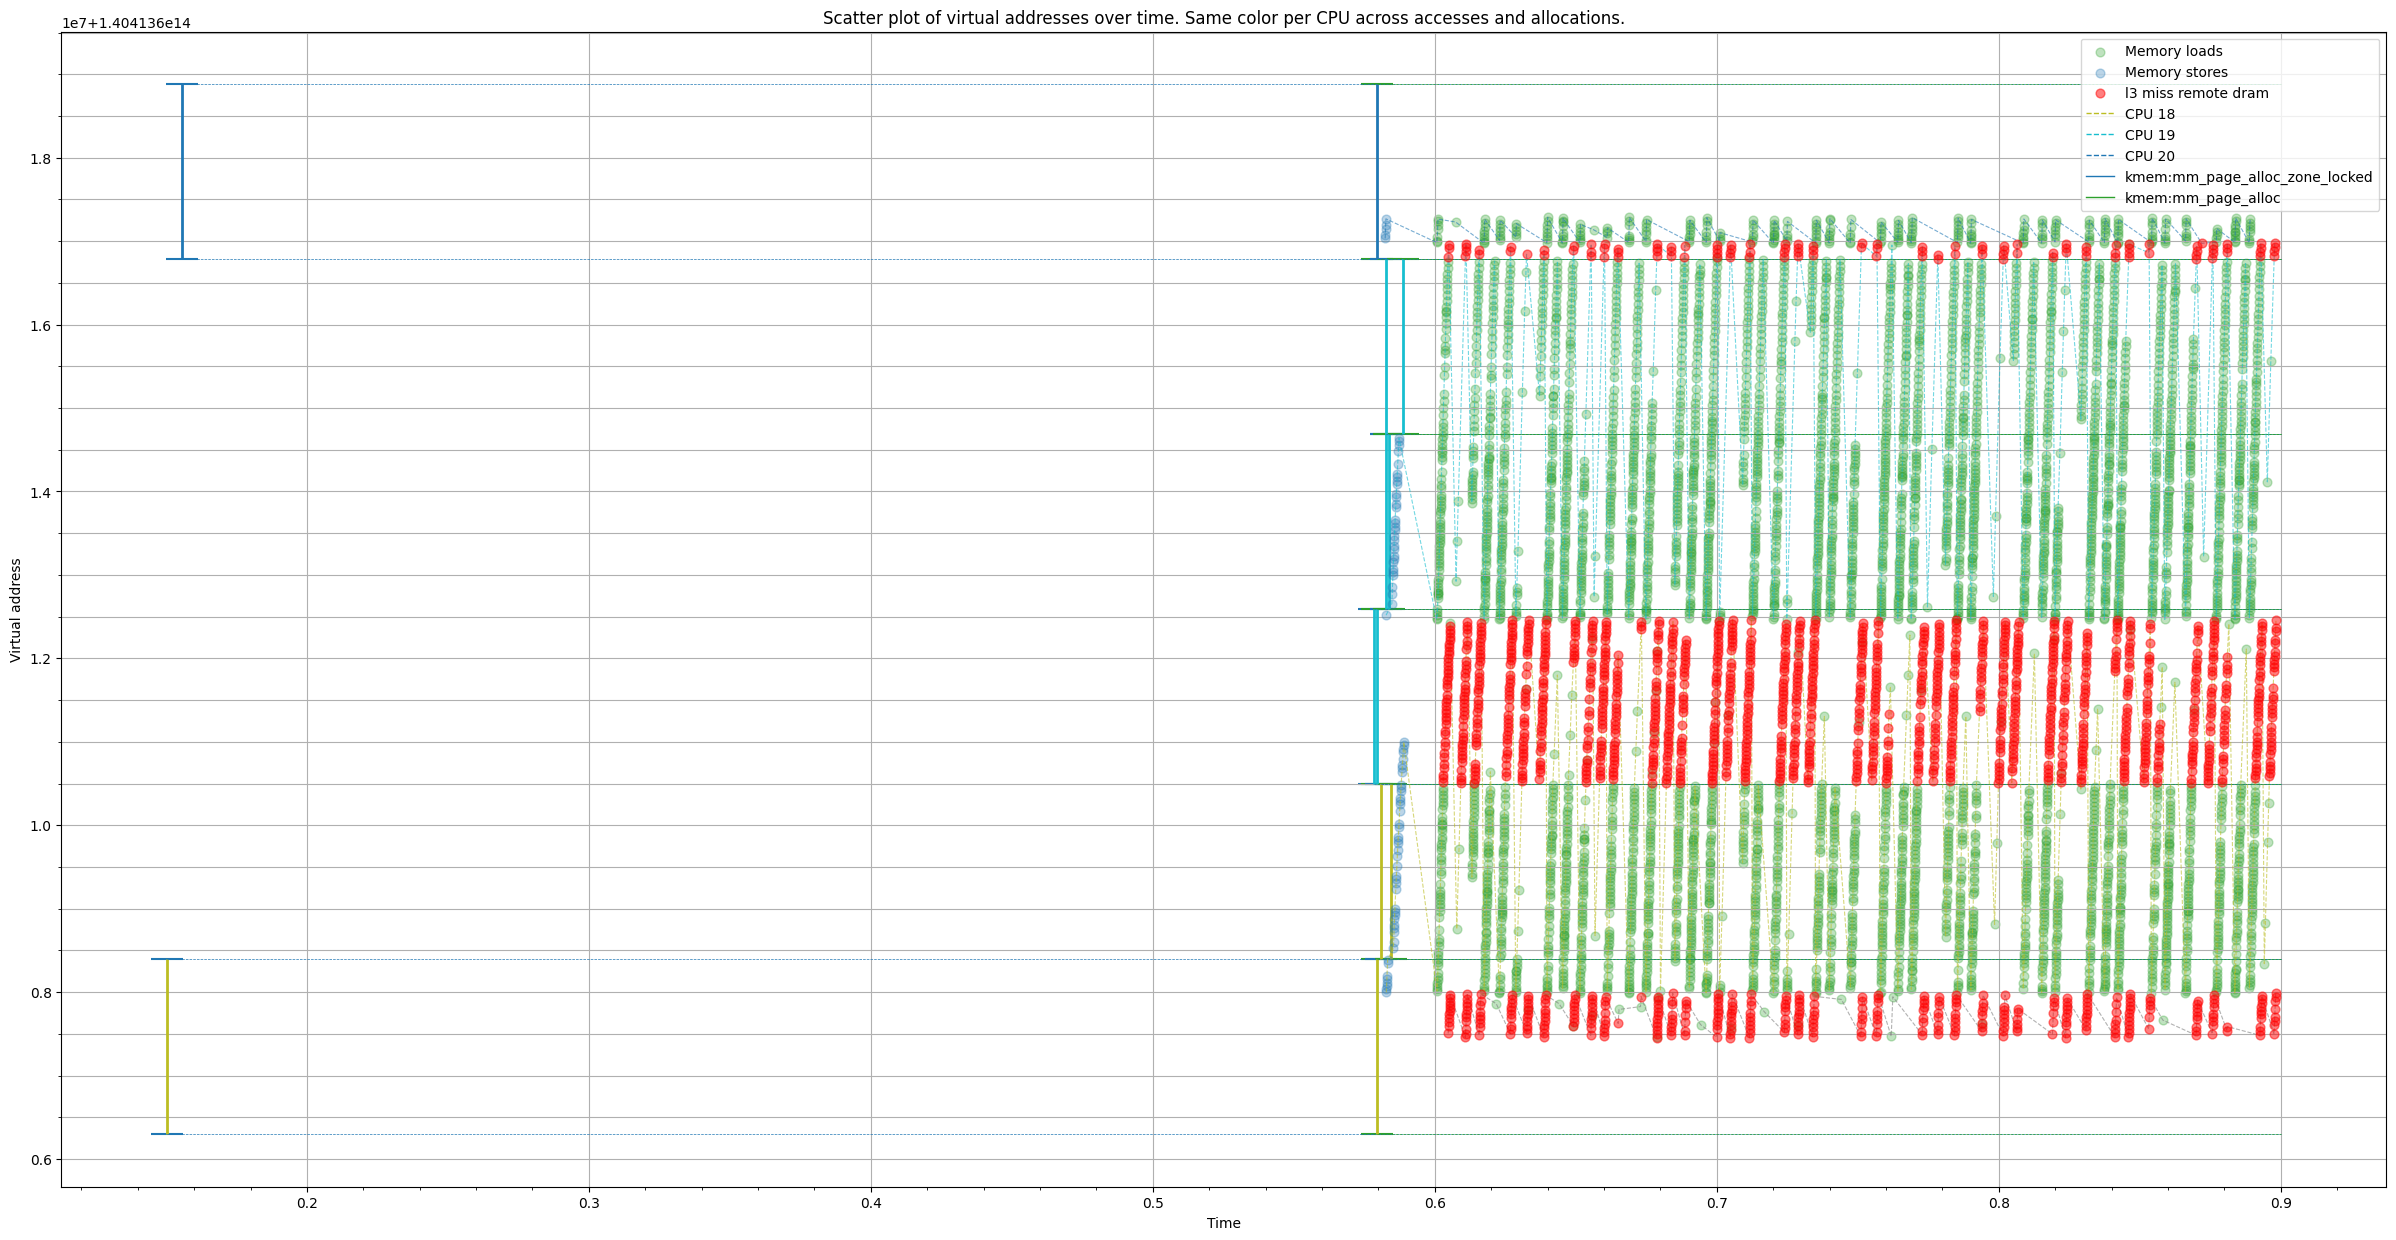

In [33]:
plot_mem_virtual(seq_data, min_addr=140413607452672, max_addr=140413617287167, max_t=0.9)

# Profiler

What we want is to systematically measure when a CPU accesses a page that is not his ?
Or maybe have a dict that contain pages that have been accessed by several CPUs ?

-> For each allocation, we will want to 

1. Deduplicate it with zone allocate, have only a single instance of the allocation
2. Filter this virtual range only, 

In [66]:
alloc_df = seq_data.alloc_df.dropna(subset=["virt_page"]) # TODO Check
# TODO Clem make virt page an int just like below
alloc_df['start_addr'] = (alloc_df['virt_page'] * perf_parser.page_size).astype(int)
alloc_df['end_addr'] = (alloc_df['start_addr'] + (2 ** alloc_df['order']) * perf_parser.page_size).astype(int) # Excluded
alloc_df.reset_index(drop=True, inplace=True)
# min_addr = 140413607452672
# max_addr = 140413617287167
# alloc_df = filter_in_bounds(seq_data.alloc_df, (None, max_addr), 'start_addr')
# alloc_df = filter_in_bounds(alloc_df, (min_addr, None), "end_addr")
alloc_df.sort_values("order", ascending=False)

/tmp/ipykernel_15030/1714901176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc_df['start_addr'] = (alloc_df['virt_page'] * perf_parser.page_size).astype(int)
/tmp/ipykernel_15030/1714901176.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc_df['end_addr'] = (alloc_df['start_addr'] + (2 ** alloc_df['order']) * perf_parser.page_size).astype(int) # Excluded


,cpuid,time,event,pfn,order,cpu_node,memory_node,virt_page,start_addr,end_addr
1122,21,0.150252,kmem:mm_page_alloc_zone_locked,25803264,9,1,1,3.428075e+10,140413958619136,140413960716288
1119,10,0.150226,kmem:mm_page_alloc,3570688,9,0,0,3.428074e+10,140413904093184,140413906190336
1118,62,0.150220,kmem:mm_page_alloc,2073600,9,0,0,3.428080e+10,140414153654272,140414155751424
1117,14,0.150220,kmem:mm_page_alloc_zone_locked,2072576,9,0,0,3.428066e+10,140413589520384,140413591617536
1116,14,0.150217,kmem:mm_page_alloc_zone_locked,3572224,9,0,0,3.428074e+10,140413925064704,140413927161856
...,...,...,...,...,...,...,...,...,...,...
1510,63,0.156610,kmem:mm_page_alloc_zone_locked,25784473,0,1,1,3.428080e+10,140414162530304,140414162534400
1511,63,0.156611,kmem:mm_page_alloc_zone_locked,25784474,0,1,1,3.428080e+10,140414162534400,140414162538496
1512,63,0.156611,kmem:mm_page_alloc_zone_locked,25784475,0,1,1,3.428084e+10,140414327963648,140414327967744
1513,63,0.156612,kmem:mm_page_alloc_zone_locked,25784476,0,1,1,3.428080e+10,140414162538496,140414162542592


In [71]:
print(hex(alloc_df.iloc[1118]["start_addr"]))
print(hex(alloc_df.iloc[1118]["end_addr"]))

alloc_df.iloc[1118]

print(alloc_df.iloc[1118]["end_addr"] - alloc_df.iloc[1118]["start_addr"])

0x7fb4b7c00000
0x7fb4b7e00000
2097152
2097152


In [35]:
seq_data.alloc_df.sort_values("order", ascending=False)

,cpuid,time,event,pfn,order,cpu_node,memory_node,virt_page
1215,41,0.081780,kmem:mm_page_alloc,25513984,9,1,1,3.428077e+10
1213,42,0.081643,kmem:mm_page_alloc,2852352,9,0,0,3.428072e+10
2845,59,0.151400,kmem:mm_page_alloc,26202624,9,1,1,3.428080e+10
1211,42,0.081413,kmem:mm_page_alloc,2852352,9,0,0,3.428072e+10
1209,41,0.081284,kmem:mm_page_alloc,25593344,9,1,1,3.428080e+10
...,...,...,...,...,...,...,...,...
2713,44,0.150397,kmem:mm_page_alloc_zone_locked,1469771,0,0,0,NaN
2711,44,0.150396,kmem:mm_page_alloc_zone_locked,1469770,0,0,0,NaN
2710,44,0.150396,kmem:mm_page_alloc_zone_locked,1469769,0,0,0,NaN
2709,44,0.150395,kmem:mm_page_alloc_zone_locked,1469768,0,0,0,NaN


In [36]:
# Let's take the first page and see if it is shared

# selected_alloc_id = 2845
selected_pfn = 26202624
selected_order = 9
min_phys = selected_pfn * perf_parser.page_size
max_phys = min_phys + perf_parser.page_size * selected_order - 1

# print(hex(min_phys), hex(max_phys))


# filter_in_bounds(seq_data.access_df, (min_phys, max_phys), "phys")

## Scanning pages for false sharing patterns

In [20]:
seq_data.alloc_df

,cpuid,time,event,pfn,order,cpu_node,memory_node
0,29,0.000000,kmem:mm_page_alloc,25467409,0,1,1
1,29,0.000001,kmem:mm_page_alloc,25467408,0,1,1
2,29,0.000035,kmem:mm_page_alloc,25467398,0,1,1
3,29,0.000035,kmem:mm_page_alloc,25467397,0,1,1
4,29,0.000038,kmem:mm_page_alloc,25623349,0,1,1
...,...,...,...,...,...,...,...
7601,0,12.456370,kmem:mm_page_alloc,1418440,0,0,0
7602,0,12.456663,kmem:mm_page_alloc,1129650,0,0,0
7603,0,12.457069,kmem:mm_page_alloc,1134413,0,0,0
7604,0,12.457152,kmem:mm_page_alloc,1184876,0,0,0


In [11]:
seq_data.alloc_df["event"].value_counts()

event
kmem:mm_page_alloc                4001
kmem:mm_page_alloc_zone_locked    3605
Name: count, dtype: int64

Leads to make that faster :

- We basically have a list of addresses
1. Instead of running through the list each time to filter all the accesses for a specific page, we can sort them linearly
Ex if we have 10M accesses, log1e7 = 23, and log 1e9 = 33
So compared to 7k it's 212 times faster, 7 min > 2 sec



In [38]:
aldf = seq_data.alloc_df
aldf = aldf.loc[aldf["order"] > 0]
aldf = aldf.sort_values("pfn", ignore_index=True)

acdf = seq_data.access_df.sort_values("phys", ignore_index=True)
acdf["pfn"] = acdf["phys"].values >> seq_data.page_size_order

In [40]:
seq_data.alloc_df

,cpuid,time,event,pfn,order,cpu_node,memory_node
0,29,0.000000,kmem:mm_page_alloc,25467409,0,1,1
1,29,0.000001,kmem:mm_page_alloc,25467408,0,1,1
2,29,0.000035,kmem:mm_page_alloc,25467398,0,1,1
3,29,0.000035,kmem:mm_page_alloc,25467397,0,1,1
4,29,0.000038,kmem:mm_page_alloc,25623349,0,1,1
...,...,...,...,...,...,...,...
7601,0,12.456370,kmem:mm_page_alloc,1418440,0,0,0
7602,0,12.456663,kmem:mm_page_alloc,1129650,0,0,0
7603,0,12.457069,kmem:mm_page_alloc,1134413,0,0,0
7604,0,12.457152,kmem:mm_page_alloc,1184876,0,0,0


In [ ]:
from time import process_time_ns

i = 0

access_idx = 0
access = acdf.iloc[access_idx]

def get_access_df_for_pfn(run_mem_data: RunMemoryData, pfn: int):
    min_phys = pfn * perf_parser.page_size
    max_phys = min_phys + perf_parser.page_size # Excluded
    return filter_in_bounds(run_mem_data.access_df, (min_phys, max_phys), "phys")

# TODO Function that gets next access

# TODO Handle case where next pfn is same because we have both mm_page_alloc and page_alloc_locked
for pfn in aldf["pfn"]:
    min_phys = pfn * perf_parser.page_size
    max_phys = min_phys + perf_parser.page_size # Excluded
    # print(f"\nNew allocation, pfn = {hex(pfn)}, min = {hex(min_phys)}, max = {hex(max_phys)}")
    # print(f"Should find {len(get_access_df_for_pfn(seq_data, pfn))} accesses")
    
    skip_start = process_time_ns()
    initial_access_idx = access_idx
    while access["phys"] < min_phys:
        # print(f"Skipping access with phys addr : {hex(access['phys'])}")
        access_idx += 1
        access = acdf.iloc[access_idx]
    skip_time = process_time_ns() - skip_start
    
    # TODO Maybe get rid of that ?
    if access['phys'] >= max_phys:
        continue
    
    print(f"\nNew allocation, pfn = {hex(pfn)}, min = {hex(min_phys)}, max = {hex(max_phys)}")
    print(f"Skipped {access_idx - initial_access_idx} accesses in {skip_time}")
        
    accesses_start = process_time_ns()
    initial_access_idx = access_idx
    while access["phys"] < max_phys:
        # if access_idx < min_phys:
        #     print(f"Access phys addr {hex(access['phys'])} is below min page phys addr, WTF")
        #     access_idx += 1
        #     access = acdf.iloc[access_idx]
        #     continue
        
        # print(f"Viable access {hex(access['phys'])}")
        access_idx += 1
        access = acdf.iloc[access_idx]
    accesses_time = process_time_ns() - accesses_start
    print(f"{access_idx - initial_access_idx} page accesses in {accesses_time}")
        
    # Next address is expected to fall within the range
    
    if i > 200:
        break
    i += 1
    
print(f"access_idx = {access_idx}")

What does it mean to have a false shared page ?
It means that each page is accessed by one CPU / Node only

First, we filter out all the order 0 pages because they cannot be false shared
7k to 939

We want to know if an allocations is false shared :
- As soon as we find a page accessed by at least 2 nodes it is not false shared. We can move to the 
- Another option is to compute the number of shared pages, but that depends on the sampling rate so it might not make much sense at all

In [96]:
aldf.loc[aldf["order"] > 0].value_counts("order")

order
9    913
3     25
2      1
Name: count, dtype: int64

In [ ]:
def old_code():
    i = 0

    access_idx = 0
    access = acdf.iloc[access_idx]


    def get_access_df_for_pfn_old(run_mem_data: RunMemoryData, pfn: int, order: int):
        min_phys = pfn * perf_parser.page_size
        max_phys = (pfn + (1 << order)) * perf_parser.page_size # Excluded
        return filter_in_bounds(run_mem_data.access_df, (min_phys, max_phys), "phys")

    # def get_access_df_for_pfn(run_mem_data: RunMemoryData, pfn: int, order: int):
    #     min_phys = pfn * perf_parser.page_size
    #     max_phys = (pfn + (1 << order)) * perf_parser.page_size # Excluded
    #     return filter_in_bounds(run_mem_data.access_df, (min_phys, max_phys), "phys")

    # TODO Function that gets next access

    alloc_pfns = aldf["pfn"].to_numpy()
    alloc_orders = aldf["order"].to_numpy()

    access_phys = acdf["phys"].to_numpy()
    access_nodes = acdf["cpu_node"].to_numpy()

    previous_pfn = -1


    not_shared_allocations_pfns = []
    true_shared_allocations_pfns = []
    false_shared_allocations_pfns = []


    # TODO Handle case where next pfn is same because we have both mm_page_alloc and page_alloc_locked
    for pfn, order in zip(alloc_pfns, alloc_orders):
        i += 1
        
        if pfn == previous_pfn:
            continue
        previous_pfn = pfn
        
        # if pfn != 0x213e18:
        #     continue
        
        min_phys = pfn * perf_parser.page_size
        max_phys = (pfn + (1 << order)) * perf_parser.page_size # Excluded
        
        initial_access_idx = access_idx
        access_idx = bisect_left(access_phys, min_phys, lo = access_idx)
        if access_phys[access_idx] >= max_phys:
            # print(f"\nSkipped allocation {i}, pfn = {hex(pfn)}, min = {hex(min_phys)}, max = {hex(max_phys)}, no memory accesses")
            continue
        
        print(f"\nAllocation {i}, order = {order}, pfn = {hex(pfn)}, min = {hex(min_phys)}, max = {hex(max_phys)}")
        print(f"Skipped {access_idx - initial_access_idx} accesses")
        
        # TODO If order is 1 then page is truly shared as soon as several nodes are accessing
        next_access_idx = bisect_left(access_phys, max_phys, lo = access_idx)
        unique_nodes = np.unique(access_nodes[access_idx:next_access_idx])
        print(f"Unique nodes : {unique_nodes}")
        if len(unique_nodes) <= 1:
            not_shared_allocations_pfns.append(pfn)
            # Page connot be false shared if it is not shared
            print("Allocation not shared")
            continue
        
        
        # TODO Remove block
        # computed_number_of_accesses = next_access_idx - access_idx
        # projected_number_of_accesses = len(get_access_df_for_pfn(seq_data, pfn, order))
        # if (projected_number_of_accesses != computed_number_of_accesses):
        #     print(f"ERROR : Projected {projected_number_of_accesses}, computed {computed_number_of_accesses}")
        
        print(f"Access addr : {hex(access_phys[access_idx])}, next access addr : {hex(access_phys[next_access_idx])}")
        is_false_shared = True
        
        accesses_start = process_time_ns()
        initial_access_idx = access_idx
        curr_pfn = -1 # access_phys[access_idx] >> perf_parser.page_size_order
        curr_node = -1 # access_nodes[access_idx]
        while access_idx < next_access_idx:
            new_pfn = access_phys[access_idx] >> perf_parser.page_size_order
            if new_pfn != curr_pfn:
                curr_pfn = new_pfn
                curr_node = access_nodes[access_idx]
            else:
                new_node = access_nodes[access_idx]
                if new_node != curr_node:
                    is_false_shared = False
                    break
            
            access_idx += 1
            # access = acdf.iloc[access_idx]
            
        if is_false_shared:
            false_shared_allocations_pfns.append(pfn)
        else :
            true_shared_allocations_pfns.append(pfn)
            
        print(f"Is false shared : {is_false_shared}, accessing nodes : {list(unique_nodes)}")
        accesses_time = process_time_ns() - accesses_start
        print(f"{access_idx - initial_access_idx} page accesses in {accesses_time / 1e6} ms")
            
        # Next address is expected to fall within the range
        
        if i > 2000:
            break
        
    print(f"access_idx = {access_idx}")

    print(f"Not shared count : {len(not_shared_allocations_pfns)}")
    print(f"True shared count : {len(true_shared_allocations_pfns)}")
    print(f"False shared count : {len(false_shared_allocations_pfns)}")

    # We want
    # Number of pages not shared
    # Number of pages truely shared
    # Number of pages false shared

    # 0x213e18

    # 0x213e19

In [46]:
def get_access_df_for_pfn(access_df: pd.DataFrame, base_pfn: int, order: int):
    max_pfn = (base_pfn + (1 << order))
    return filter_in_bounds(access_df, (base_pfn, max_pfn), "pfn")

In [47]:
acdf

,cpuid,time,period,event,virt,cache_result,latency,phys,cpu_node,memory_node,pfn
0,61,10.227091,200,mem_load_l3_miss_retired.remote_dram:P,18446638216724634208,LVL N/A or N/A,0,4295252576,1,0,1048645
1,36,8.384503,200,mem_load_l3_miss_retired.local_dram:P,18446638216724713472,LVL N/A or N/A,0,4295331840,0,0,1048665
2,9,8.568508,200,mem_load_l3_miss_retired.remote_fwd:P,18446638216724713544,LVL N/A or N/A,0,4295331912,1,0,1048665
3,10,5.296503,200,mem_load_l3_miss_retired.local_dram:P,18446638216724713552,LVL N/A or N/A,0,4295331920,0,0,1048665
4,22,9.736509,200,mem_load_l3_miss_retired.local_dram:P,18446638216724713648,LVL N/A or N/A,0,4295332016,0,0,1048665
...,...,...,...,...,...,...,...,...,...,...,...
11644003,0,12.459578,2000,"cpu/mem-stores,period=2000/P",18446638419661377864,LVL L1 or N/A hit,0,207231996232,0,1,50593749
11644004,51,0.154200,2000,"cpu/mem-stores,period=2000/P",18446638419661377864,LVL L1 or N/A hit,0,207231996232,1,1,50593749
11644005,51,0.597185,2000,"cpu/mem-stores,period=2000/P",18446638419661547464,LVL L1 or N/A hit,0,207232165832,1,1,50593790
11644006,0,12.455658,2000,"cpu/mem-stores,period=2000/P",18446638419661547600,LVL L1 or N/A hit,0,207232165968,0,1,50593790


In [136]:
def compute_page_sharing_stats(run_data: RunMemoryData):
    allocation_df = run_data.alloc_df
    allocation_df = allocation_df.loc[allocation_df["order"] > 0]
    n_filtered_allocations = len(allocation_df)
    print(f"Filtered out {len(run_data.alloc_df)} single page allocations ({n_filtered_allocations} remaining)")
    allocation_df = allocation_df.sort_values("pfn", ignore_index=True)
    print("Sorted allocations")

    access_df = run_data.access_df.sort_values("phys", ignore_index=True)
    print(f"Sorted {len(access_df) / 1e6} million accesses")
    access_df["pfn"] = access_df["phys"].values >> run_data.page_size_order
    print("Computed accesses pfns")
    
    access_idx = 0

    alloc_pfns = allocation_df["pfn"].to_numpy()
    alloc_orders = allocation_df["order"].to_numpy()
    access_pfns = access_df["pfn"].to_numpy()
    access_cpus = access_df["cpuid"].to_numpy()
    access_nodes = access_df["cpu_node"].to_numpy()

    previous_pfn = -1 # TODO rename previous_alloc_pfn
    
    not_shared_allocations_pfns = []
    # For each allocation, how many small pages are shared
    n_node_shared_pages_per_allocation_pfn = {}
    n_cpu_shared_pages_per_allocation_pfn = {}

    # TODO Handle case where next pfn is same because we have both mm_page_alloc and page_alloc_locked
    for alloc_pfn, order in zip(alloc_pfns, alloc_orders):
        if alloc_pfn == previous_pfn:
            continue
        previous_pfn = alloc_pfn
        max_alloc_pfn = alloc_pfn + (1 << order)

        initial_access_idx = access_idx # TODO Should not be necessary
        access_idx = bisect_left(access_pfns, alloc_pfn, lo = access_idx)
        if access_pfns[access_idx] >= max_alloc_pfn:
            # print(f"\nSkipped allocation {i}, alloc_pfn = {hex(pfalloc_pfnn)}, max_alloc_pfn = {hex(max_alloc_pfn)}, no memory accesses")
            continue

        # print(f"\nAllocation {i}, n pages = {1 << order}, alloc_pfn = {hex(alloc_pfn)}, max_alloc_pfn = {hex(max_alloc_pfn)}")
        # print(f"Skipped {access_idx - initial_access_idx} accesses")

        # TODO If order is 1 then page is truly shared as soon as several nodes are accessing
        next_access_idx = bisect_left(access_pfns, max_alloc_pfn, lo = access_idx)
        unique_cpus = np.unique(access_cpus[access_idx:next_access_idx]) # TODO Make sure we are not including the next index
        if len(unique_nodes) <= 1:
            not_shared_allocations_pfns.append(alloc_pfn)
            # Page connot be false shared if it is not shared
            continue

        # print(f"Access pfn : {hex(access_pfns[access_idx])}, next access pfn : {hex(access_pfns[next_access_idx])}")

        n_node_shared_pages = 0
        n_cpu_shared_pages = 0

        curr_pfn = -1
        curr_cpu = -1
        curr_node = -1
        is_page_cpu_shared = False
        is_page_node_shared = False
        # We want to count the number of pages that are shared either just by CPUs or between nodes
        while access_idx < next_access_idx:
            if access_pfns[access_idx] != curr_pfn:
                # print(f"New pfn : {access_pfns[access_idx]}")
                if is_page_node_shared:
                    n_cpu_shared_pages += 1
                    n_node_shared_pages += 1
                elif is_page_cpu_shared:
                    n_cpu_shared_pages += 1
                
                curr_pfn = access_pfns[access_idx]
                curr_cpu = access_cpus[access_idx]
                curr_node = access_nodes[access_idx]
                is_page_cpu_shared = False
                is_page_node_shared = False
                
            elif access_nodes[access_idx] != curr_node:
                is_page_node_shared = True
                # Nothing to see on that page anymore
                access_idx = bisect_left(access_pfns, curr_pfn + 1, lo = access_idx)
                # print(f"Page is node shared. Curr pfn : {curr_pfn}, new pfn : {access_pfns[access_idx]}")
                
                
            elif access_cpus[access_idx] != curr_cpu:
                is_page_cpu_shared = True
                # print(f"Page is cpu shared : {curr_cpu} and {access_cpus[access_idx]}")
                
            access_idx += 1
            
        n_node_shared_pages_per_allocation_pfn[alloc_pfn] = n_node_shared_pages
        n_cpu_shared_pages_per_allocation_pfn[alloc_pfn] = n_cpu_shared_pages
        
    
    return not_shared_allocations_pfns, n_node_shared_pages_per_allocation_pfn, n_cpu_shared_pages_per_allocation_pfn, n_filtered_allocations
    

In [137]:
not_shared_pfns, n_node_shared_pages, n_cpu_shared_pages, n_filtered_allocations = compute_page_sharing_stats(seq_data)

Filtered out 7606 single page allocations (914 remaining)
Sorted allocations
Sorted 11.644008 million accesses
Computed accesses pfns


In [138]:
n_alloc_node_shared = sum(np.array(list(n_node_shared_pages.values()), dtype=int) == 0)
n_alloc_cpu_shared = sum(np.array(list(n_cpu_shared_pages.values()), dtype=int) == 0)

print(f"Not shared pages : {len(not_shared_allocations_pfns)}. Node false shared huge pages : {n_alloc_node_shared}, cpu false shared : {n_alloc_cpu_shared}")


Not shared pages : 174. Node false shared huge pages : 31, cpu false shared : 31


dict_values([1, 1, 1, 1, 0, 8, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 61, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 2, 1, 3, 1, 1, 2, 1, 2, 6, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 44, 2, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 4, 1, 2, 1, 1, 1, 1, 2, 3, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 59, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 3, 1, 2, 0, 1, 1, 3, 1, 1, 1, 0, 57, 1, 1, 1, 1, 1, 1, 1, 2, 5, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 7, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 1, 0, 3, 6, 0, 1, 1, 7, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1])

In [64]:
from time import process_time_ns
from bisect import bisect_left

i = 0

access_idx = 0
access = acdf.iloc[access_idx]


# TODO Function that gets next access

alloc_pfns = aldf["pfn"].to_numpy()
alloc_orders = aldf["order"].to_numpy()

access_pfns = acdf["pfn"].to_numpy()
access_cpus = acdf["cpuid"].to_numpy()
access_nodes = acdf["cpu_node"].to_numpy()

previous_pfn = -1 # TODO rename previous_alloc_pfn


not_shared_allocations_pfns = []
true_shared_allocations_pfns = []
false_shared_allocations_pfns = []

# For each allocation, how many small pages are shared
# TODO Wrap the whole thing in a function and make sure we only have order > 0 allocations
numbers_of_node_shared_pages = []
numbers_of_cpu_shared_pages = []

# TODO Handle case where next pfn is same because we have both mm_page_alloc and page_alloc_locked
for alloc_pfn, order in zip(alloc_pfns, alloc_orders):
    i += 1
    
    if alloc_pfn == previous_pfn:
        continue
    previous_pfn = alloc_pfn
    max_alloc_pfn = alloc_pfn + (1 << order)
    
    # if alloc_pfn != 0x1912c00:
    #     continue
    
    initial_access_idx = access_idx # TODO Should not be necessary
    access_idx = bisect_left(access_pfns, alloc_pfn, lo = access_idx)
    if access_pfns[access_idx] >= max_alloc_pfn:
        # print(f"\nSkipped allocation {i}, alloc_pfn = {hex(pfalloc_pfnn)}, max_alloc_pfn = {hex(max_alloc_pfn)}, no memory accesses")
        continue
    
    print(f"\nAllocation {i}, n pages = {1 << order}, alloc_pfn = {hex(alloc_pfn)}, max_alloc_pfn = {hex(max_alloc_pfn)}")
    print(f"Skipped {access_idx - initial_access_idx} accesses")
    
    # TODO If order is 1 then page is truly shared as soon as several nodes are accessing
    next_access_idx = bisect_left(access_pfns, max_alloc_pfn, lo = access_idx)
    unique_nodes = np.unique(access_nodes[access_idx:next_access_idx]) # TODO Make sure we are not including the next index
    print(f"Unique nodes : {unique_nodes}")
    if len(unique_nodes) <= 1:
        not_shared_allocations_pfns.append(alloc_pfn)
        # Page connot be false shared if it is not shared
        print("Allocation not shared")
        continue
    
    
    # TODO Remove block
    # computed_number_of_accesses = next_access_idx - access_idx
    # projected_number_of_accesses = len(get_access_df_for_pfn(seq_data, alloc_pfn, order))
    # if (projected_number_of_accesses != computed_number_of_accesses):
    #     print(f"ERROR : Projected {projected_number_of_accesses}, computed {computed_number_of_accesses}")
    
    print(f"Access pfn : {hex(access_pfns[access_idx])}, next access pfn : {hex(access_pfns[next_access_idx])}")
    is_false_shared = True
    
    accesses_start = process_time_ns()
    # Goal of this section is to see if any individual page is accessed by 2+ CPU / nodes at a time
    # Remember that we may have a very coarse sampling rate, so making precise sampling does not make much sense
    # However we can try and see if the accesses are separate in time ?
    # Like for each shared page, what is the minimum time between two shared accesses ?
    
    # At a minimum, we want to know if a page is shared between several cpus, if not between several nodes
    has_node_shared_pages = False
    has_cpu_shared_pages = False
    
    n_node_shared_pages = 0
    n_cpu_shared_pages = 0
    
    curr_pfn = -1
    curr_cpu = -1
    curr_node = -1
    is_page_cpu_shared = False
    is_page_node_shared = False
    # We want to count the number of pages that are shared either just by CPUs or between nodes
    while access_idx < next_access_idx:
        if access_pfns[access_idx] != curr_pfn:
            # print(f"New pfn : {access_pfns[access_idx]}")
            if is_page_node_shared:
                n_cpu_shared_pages += 1
                n_node_shared_pages += 1
            elif is_page_cpu_shared:
                n_cpu_shared_pages += 1
            
            curr_pfn = access_pfns[access_idx]
            curr_cpu = access_cpus[access_idx]
            curr_node = access_nodes[access_idx]
            is_page_cpu_shared = False
            is_page_node_shared = False
            
        elif access_nodes[access_idx] != curr_node:
            is_page_node_shared = True
            # Nothing to see on that page anymore
            access_idx = bisect_left(access_pfns, curr_pfn + 1, lo = access_idx)
            print(f"Page is node shared. Curr pfn : {curr_pfn}, new pfn : {access_pfns[access_idx]}")
            
            
        elif access_cpus[access_idx] != curr_cpu:
            is_page_cpu_shared = True
            print(f"Page is cpu shared : {curr_cpu} and {access_cpus[access_idx]}")
            
        access_idx += 1
        
        
    numbers_of_node_shared_pages.append(n_node_shared_pages)
    numbers_of_cpu_shared_pages.append(n_cpu_shared_pages)
            
    # if n_node_shared_pages > 0:
    #     print(f"Huge page is node shared ({n_cpu_shared_pages} cpu-shared pages, among which {n_node_shared_pages} node-shared pages)")
    #     false_shared_allocations_pfns.append(alloc_pfn)
    # else :
    #     print("Huge page is false shared")
    #     true_shared_allocations_pfns.append(alloc_pfn)
        
    # # print(f"Is false shared : {is_false_shared}, accessing nodes : {list(unique_nodes)}")
    # accesses_time = process_time_ns() - accesses_start
    # print(f"{access_idx - initial_access_idx} page accesses in {accesses_time / 1e6} ms")
        
    # Next address is expected to fall within the range
    
    if i > 2000:
        break
    
# print(f"access_idx = {access_idx}")

# print(f"Not shared count : {len(not_shared_allocations_pfns)}")
# print(f"True shared count : {len(true_shared_allocations_pfns)}")
# print(f"False shared count : {len(false_shared_allocations_pfns)}")

# We want
# Number of pages not shared
# Number of pages truely shared
# Number of pages false shared

# We are going to plot a histogram of the number of huge pages that have n small pages shared, both between cpus and nodes



Allocation 1, n pages = 8, alloc_pfn = 0x112f50, max_alloc_pfn = 0x112f58
Skipped 4789 accesses
Unique nodes : [0 1]
Access pfn : 0x112f50, next access pfn : 0x112f88
Page is cpu shared : 43 and 37
Page is node shared. Curr pfn : 1126224, new pfn : 1126226
Page is cpu shared : 12 and 42

Allocation 2, n pages = 8, alloc_pfn = 0x112f88, max_alloc_pfn = 0x112f90
Skipped 0 accesses
Unique nodes : [0 1]
Access pfn : 0x112f88, next access pfn : 0x112f91
Page is node shared. Curr pfn : 1126282, new pfn : 1126283
Page is node shared. Curr pfn : 1126285, new pfn : 1126289

Allocation 3, n pages = 512, alloc_pfn = 0x117600, max_alloc_pfn = 0x117800
Skipped 18022 accesses
Unique nodes : [0 1]
Access pfn : 0x117600, next access pfn : 0x118052
Page is node shared. Curr pfn : 1144347, new pfn : 1144348

Allocation 5, n pages = 512, alloc_pfn = 0x119c00, max_alloc_pfn = 0x119e00
Skipped 14295 accesses
Unique nodes : [0]
Allocation not shared

Allocation 7, n pages = 512, alloc_pfn = 0x119e00, max_a

In [67]:
len(numbers_of_node_shared_pages)

276

In [106]:
np.arange(12) - 0.5

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5])

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10+']


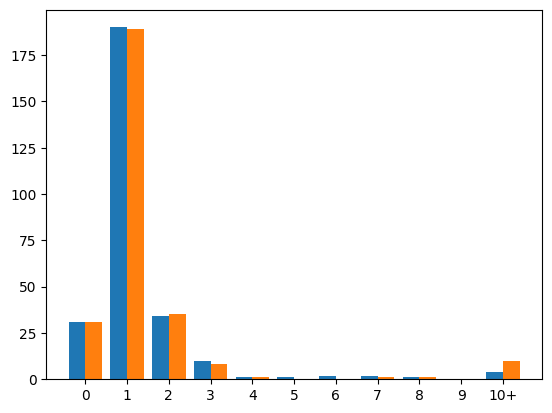

In [111]:
bins = np.arange(12) - 0.5

# bins = np.arange(10)

plt.hist(
    [np.clip(numbers_of_node_shared_pages, bins[0], bins[-1]), 
     np.clip(numbers_of_cpu_shared_pages, bins[0], bins[-1])],
    bins = bins)
# plt.hist(numbers_of_node_shared_pages, bins = bins)

xticks = bins[:-1] + 0.5
xlabels = xticks.astype(int).astype(str)
xlabels[-1] += '+'

print(xlabels)

# N_labels = len(xlabels)
# plt.xlim([0, 5])
# # plt.xticks(25 * np.arange(N_labels) + 12.5)
# # ax.set_xticklabels(xlabels)

plt.xticks(xticks)
plt.gca().set_xticklabels(xlabels)

plt.show()

In [118]:
n_alloc_node_shared = sum(np.array(numbers_of_node_shared_pages) == 0)
n_alloc_cpu_shared = sum(np.array(numbers_of_cpu_shared_pages) == 0)

print(f"Number of false node shared allocations : {}")

In [150]:
test_pfn = 0x11a01b

filtered_access_df = get_access_df_for_pfn(seq_data, test_pfn, 0)
filtered_access_df.value_counts("cpu_node")

cpu_node
1    17
0     4
Name: count, dtype: int64

In [135]:
hex(filtered_access_df["phys"].min())

'0x11b8b3210'

In [22]:
aldf.loc[aldf["pfn"] == 0x18b8000]

,cpuid,time,event,pfn,order,cpu_node,memory_node
642,3,0.595890,kmem:mm_page_alloc,25919488,9,1,1
643,3,0.594815,kmem:mm_page_alloc_zone_locked,25919488,9,1,1


Now what can we want to learn ?
- How many pages out of how many are shared

In [23]:
get_access_df_for_pfn(seq_data, 0x18b8000, 9)

,cpuid,time,period,event,virt,cache_result,latency,phys,cpu_node,memory_node
1854531,3,0.598919,2000,"cpu/mem-stores,period=2000/P",140315615814464,LVL L1 or N/A miss,0,106167264064,1,1
1854594,3,0.598963,2000,"cpu/mem-stores,period=2000/P",140315615853472,LVL L1 or N/A hit,0,106167303072,1,1
1854662,3,0.599009,2000,"cpu/mem-stores,period=2000/P",140315615893216,LVL L1 or N/A hit,0,106167342816,1,1
1854735,3,0.599059,2000,"cpu/mem-stores,period=2000/P",140315615932064,LVL L1 or N/A hit,0,106167381664,1,1
1855133,3,0.599286,2000,"cpu/mem-stores,period=2000/P",140315616088928,LVL L1 or N/A miss,0,106167538528,1,1
...,...,...,...,...,...,...,...,...,...,...
11640204,3,12.449224,200,mem_load_l3_miss_retired.local_dram:P,140315616673216,LVL N/A or N/A,0,106168122816,1,1
11640288,3,12.449290,200,mem_load_l3_miss_retired.local_dram:P,140315616754560,LVL N/A or N/A,0,106168204160,1,1
11640330,3,12.449323,200,mem_load_l3_miss_retired.local_dram:P,140315616795992,LVL N/A or N/A,0,106168245592,1,1
11640375,3,12.449354,200,mem_load_l3_miss_retired.local_dram:P,140315616831808,LVL N/A or N/A,0,106168281408,1,1


In [25]:
seq_data.page_size_order

12

In [32]:
acdf["page"] = acdf["phys"].values >> seq_data.page_size_order